# 1. Introduction

## 1.1. Présentation du projet et explication de la démarche


## 1.2. Chargement des packages

In [60]:
import pandas as pd
import geopandas as gpd
import numpy as np

from shapely.geometry import Point
from pynsee.geodata import get_geodata_list, get_geodata, GeoFrDataFrame

from outils import *

from matplotlib import pyplot as plt
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
from io import BytesIO


## 1.3. Chargement des données

### 1.3.1. Données INSEE
On commence par charger la base de données 'données locales' qui contient entre autre
* Le nom des communes française
* Leur population au dernier recensement
* Leur coordonnées géographiques des communes
On s'aide pour cela de la documentation de pynsee (les commandes ici sont utilisable sans clé API)

In [2]:
# On récupère la liste géographique
geodata_list = get_geodata_list()
# On récupère la liste des limites géographique des départements
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')

mapcom_raw = gpd.GeoDataFrame(com).set_crs("EPSG:3857")

#Le jeu de données contenant les informations que nous cherchons est le suivant
mapcom_raw.sample(5)

100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


,id,nom,nom_m,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,crsCoord
6018,COMMUNE_0000000009760989,L'Isle-en-Dodon,L'ISLE-EN-DODON,31239,Commune simple,1628,06,2,31,76,200072643,"MULTIPOLYGON (((89866.195 5373049.817, 89893.5...",EPSG:3857
23833,COMMUNE_0000000009753784,Thélis-la-Combe,THELIS-LA-COMBE,42310,Commune simple,143,08,3,42,84,244200622,"MULTIPOLYGON (((504078.315 5679631.033, 504245...",EPSG:3857
25518,COMMUNE_0000000009737395,Haussignémont,HAUSSIGNEMONT,51284,Commune simple,302,20,4,51,44,200042992,"MULTIPOLYGON (((530246.781 6226934.673, 530084...",EPSG:3857
23002,COMMUNE_0000000009758970,Verquières,VERQUIERES,13116,Commune simple,790,07,2,13,93,200035087,"MULTIPOLYGON (((548314.337 5442496.38, 548516....",EPSG:3857
28218,COMMUNE_0000000009748451,La Chaumusse,LA CHAUMUSSE,39126,Commune simple,393,15,3,39,27,243900610,"MULTIPOLYGON (((660846.275 5873446.864, 660715...",EPSG:3857


In [199]:
# Surtout dans les DROM-COM certaines communes apparaissent aussi comme sous-préféctures,par exemple:
mapcom_raw[(mapcom_raw['nom_m'] == 'SAINT-CLAUDE')]


,id,nom,nom_m,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,crsCoord
6,COMMUNE_0000001169858685,Saint-Claude,SAINT-CLAUDE,97124,Commune simple,10700,06,1,971,01,249710070,"MULTIPOLYGON (((-6869802.488 1804329.757, -687...",EPSG:3857
27957,COMMUNE_0000000009749074,Saint-Claude,SAINT-CLAUDE,39478,Sous-préfecture,8727,14,3,39,27,200026573,"MULTIPOLYGON (((648695.631 5837666.044, 648666...",EPSG:3857


In [3]:
# Ainsi, certaines communes apparaisent en double en tant que sous-préféctures, on ne garde ici que les communes

# On identifie les doublons dans la colonne 'nom_m'
duplicates = mapcom_raw[mapcom_raw['nom_m'].duplicated(keep=False)]

# On sélectionne les lignes où 'statut' est égal à 'Commune simple'
simple_communes = duplicates[duplicates['statut'] == 'Commune simple']

# On conserve les lignes avec des 'nom_m' uniques ou celles avec 'Commune simple' lorsque des doublons existent
mapcom = pd.concat([
    mapcom_raw[~mapcom_raw['nom_m'].duplicated(keep=False)],  # Lignes sans doublons
    simple_communes  # Lignes où 'Commune simple' est sélectionné
]).drop_duplicates(subset='nom_m', keep='first')  # S'assurer que 'nom_m' est unique dans le résultat final

# Réinitialiser l'index pour plus de clarté 
mapcom.reset_index(drop=True, inplace=True)

# Afficher le DataFrame final
mapcom.sample(5)


,id,nom,nom_m,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,crsCoord
25178,COMMUNE_0000000009746709,Chissey-sur-Loue,CHISSEY-SUR-LOUE,39149,Commune simple,318,10,1,39,27,243900420,"MULTIPOLYGON (((643293.944 5954232.271, 643272...",EPSG:3857
25739,COMMUNE_0000000009742163,Poinson-lès-Nogent,POINSON-LES-NOGENT,52396,Commune simple,139,11,1,52,44,200068658,"MULTIPOLYGON (((600231.03 6108013.55, 600388.0...",EPSG:3857
29150,COMMUNE_0000000009735812,Dolving,DOLVING,57180,Commune simple,343,21,5,57,44,200068146,"MULTIPOLYGON (((783526.535 6234135.995, 783204...",EPSG:3857
10041,COMMUNE_0000000009755539,Saint-Michel-Loubéjou,SAINT-MICHEL-LOUBEJOU,46284,Commune simple,410,06,2,46,76,200066371,"MULTIPOLYGON (((207761.528 5603536.707, 207717...",EPSG:3857
19568,COMMUNE_0000000009727832,Dechy,DECHY,59170,Commune simple,5351,01,3,59,32,200044618,"MULTIPOLYGON (((348333.299 6502861.601, 348257...",EPSG:3857


### 1.3.2. Données Géod'air

Les données Géod'air sont un jeu de données issue de Géod'air le pourvoyeur public de données sur la pollution atmosphériques. Elles consistent en des jeux de données .csv tékéchargées préalablements représentant la mesure de 5 polluants différents et des informations conjointes (nom et lieux des sites de meusures, types de mesures, etc.) regroupés par intervalles de 6 mois entre le 1er janvier 2020 et le 31 décembre 2023.
On compte donc au total 40 fichiers .csv.

**Remarque :** Pour obtenir les données une API existe, cependant celle ci ne permet que d'obtenir des données par intervals de 1 jour, afin de gagner du temps dans les requêtes et pour ne pas risquer de surcharger les serveurs de Géod'air nous avons préféré utiliser leur outil de chargement sur-mesure des données

In [4]:
folder_paths = [
   r"CSV_data\GEODAIR\NO2\NO2_moy_hor_per", #Utiliser soit r"..." soit des \\ sinon les "\N" de "\NO2" posent problème
    "CSV_data\GEODAIR\O3\O3_moy_hor_per",
    "CSV_data\GEODAIR\PM2.5\PM2.5_moy_jour_per",
    "CSV_data\GEODAIR\PM10\PM10_moy_jour_per",
    "CSV_data\GEODAIR\SO2\SO2_moy_hor_per"
    ]

#Ici l'instruction "range(8,1,-1)" permet de classer les chemins du plus récent au moins récent.
all_file_paths = [[ folder + str(i) + ".csv" for i in range(8,0,-1)] for folder in folder_paths]

# On combine les 40 (5x8) jeux de données en 5 dataframes allant de janvier 2020 à décembre 2023
# Pour les polluants dans l'ordre suivant: NO2, O3, PM2.5, PM10, SO2
all_combined_df = [pd.concat([pd.read_csv(file, sep = ";") for file in all_file_paths[i]]) for i in range(5)]

#On obtien une liste de 5 dataframes, soit un par polluant

In [8]:
# On souhaite avoir un jeu de données pour lesquels seuls les mesures ayant mesuré tous les polluants sont conservés
# On précise les colonnes sur lesquels on applique la jonction
join_columns = ["Date de début", "Date de fin", "code site"]

# On sélectionne le data frame avec le plus petit nombre de lignes
smallest_df = min(all_combined_df, key=len)

# On initialise avec les plus petit data frame
result_df = smallest_df

# On joint chaque dataframe de notre liste "all_combined_df" avec un suffixe unique
for i, df in enumerate(all_combined_df):
    if df is not smallest_df:  # pour éviter l'auto-jonction
        result_df = pd.merge(
            result_df, 
            df, 
            on=join_columns, 
            how='inner', 
            suffixes=(None, f'_df{i}')  # Un suffixe unique pour chaque data frame
        )

# result_df contient maintenant le inner join of de tous les data frames sur les colonnes spécifées
# On obtient un objet qui contient beaucoup plus de variable que ce qui nous intéresse, on vien donc procéder à un premier tri

# Soit la liste des variables les plus utiles, on peut l'utiliser pour extraire un version synthétique du de result_df
best_variables = [
    'Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 'code site', 'nom site', "type d'implantation", 'Latitude', 'Longitude',
    'Polluant', "type d'influence", 'type de valeur', 'valeur', 'valeur brute', 'unité de mesure','code qualité', 'validité',
    'Polluant_df0', 'type de valeur_df0', 'valeur_df0', 'valeur brute_df0', 'unité de mesure_df0','code qualité_df0', 'validité_df0',
    'Polluant_df1', 'type de valeur_df1', 'valeur_df1', 'valeur brute_df1', 'unité de mesure_df1','code qualité_df1', 'validité_df1',
    'Polluant_df2', 'type de valeur_df2', 'valeur_df2', 'valeur brute_df2', 'unité de mesure_df2','code qualité_df2', 'validité_df2',
    'Polluant_df3', 'type de valeur_df3', 'valeur_df3', 'valeur brute_df3', 'unité de mesure_df3','code qualité_df3', 'validité_df3',
]

best_df = result_df[best_variables]

# Etape cosmétique pour faciliter la lecture des données intermédiaires
# On définit une fonction pour renommer les colonnes
# Définir les colonnes qui doivent garder leur nom tel quel
columns_to_keep = [
    'Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 
    'code site', 'nom site', "type d'implantation", 'Latitude', 'Longitude'
]

# Définir la fonction pour renommer les colonnes
def rename_columns(column_name):
    # Vérifier si la colonne doit conserver son nom
    if column_name in columns_to_keep:
        return column_name
    # Ajouter le suffixe "_SO2" pour les colonnes sans suffixe qui ne sont pas dans columns_to_keep
    elif not any(column_name.endswith(suffixe) for suffixe in ["_df0", "_df1", "_df2", "_df3"]):
        return f"{column_name}_SO2"
    # Remplacer les suffixes spécifiques
    elif column_name.endswith("_df0"):
        return column_name.replace("_df0", "_NO2")
    elif column_name.endswith("_df1"):
        return column_name.replace("_df1", "_O3")
    elif column_name.endswith("_df2"):
        return column_name.replace("_df2", "_PM2.5")
    elif column_name.endswith("_df3"):
        return column_name.replace("_df3", "_PM10")
    else:
        return column_name

best_df = best_df.rename(columns=rename_columns)


# Pour l'instant les données ne sont pas dans un format géographique, on transforme donc le dataframe en GeoDataFrame
best_dfgeo = gpd.GeoDataFrame(
    best_df, geometry=gpd.points_from_xy(best_df.Longitude, best_df.Latitude)
)

# Une visualisation des données donne donc:
best_dfgeo.sample(5)

,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Latitude,Longitude,...,code qualité_PM2.5,validité_PM2.5,Polluant_PM10,type de valeur_PM10,valeur_PM10,valeur brute_PM10,unité de mesure_PM10,code qualité_PM10,validité_PM10,geometry
12870,2021/11/27 00:00:00,2021/11/27 23:59:59,ATMO NORMANDIE,FR28ZAR01,ZAR LE-HAVRE,FR05090,Le Havre ville-haute,Urbaine,49.514686,0.100645,...,A,1,PM10,Moy. journalière,13.0,12.641667,µg-m3,A,1,POINT (0.10064 49.51469)
13307,2021/12/27 00:00:00,2021/12/27 23:59:59,ATMO GRAND EST,FR44ZRE01,ZR GRAND-EST,FR30033,Jonville en Woevre,Rurale régionale,49.065830,5.785556,...,A,1,PM10,Moy. journalière,9.0,9.445833,µg-m3,A,1,POINT (5.78556 49.06583)
4602,2023/05/08 00:00:00,2023/05/08 23:59:59,ATMO HAUTS DE FRANCE,FR32ZRE01,ZR HAUTS-DE-FRANCE,FR18042,P. Roth St Quentin,Urbaine,49.851334,3.284000,...,A,1,PM10,Moy. journalière,9.0,9.308333,µg-m3,A,1,POINT (3.284 49.85133)
5628,2022/07/10 00:00:00,2022/07/10 23:59:59,ATMO REUNION,FR04ZAR01,ZAR SAINT-DENIS,FR38020,Plateau Caillou,Urbaine,-21.022112,55.266773,...,A,1,PM10,Moy. journalière,10.0,10.075000,µg-m3,A,1,POINT (55.26677 -21.02211)
8543,2022/02/01 00:00:00,2022/02/01 23:59:59,ATMO REUNION,FR04ZAR01,ZAR SAINT-DENIS,FR38020,Plateau Caillou,Urbaine,-21.022112,55.266773,...,N,-1,PM10,Moy. journalière,19.0,18.712500,µg-m3,N,-1,POINT (55.26677 -21.02211)


In [5]:
#On revient maintenant à notre liste de dataframe, afin de pouvoir identifier les communes au sein desquelles les mesures ont été faites
#Pour rappel, on a tous les df dans la liste all_combined_df
result = []
result_simple = []
result_simple_agg = []
geometries = []
variable_gdf = []

# On séléctionne les variables les plus intéréssantes pour le projet 
variable_interet = ['Date de fin',
                    "type d'implantation",
                    "type d'influence", 
                    'valeur', 
                    'geometry',
                    'index_right', 
                    'id', 
                    'nom', 
                    'nom_m', 
                    'insee_com', 
                    'statut',
                    'population', 
                    'insee_can', 
                    'insee_arr', 
                    'insee_dep', 
                    'insee_reg',
                    'siren_epci', 
                    'crsCoord'
                    ]

for indice_polluant in range(5):
    gdf = gpd.GeoDataFrame(all_combined_df[indice_polluant], geometry=gpd.points_from_xy(all_combined_df[indice_polluant].Longitude, all_combined_df[indice_polluant].Latitude)).set_crs('EPSG:4326') #EPSG:4326 est le CRS correspondant aux longitudes-latitudes
    #On projette mapcom les données dans le même CRS
    mapcom = mapcom.to_crs(gdf.crs) 
    #Jonction spatiale, l'argument within identifie les coordonnées qui sont au sein des géométries des communes
    result.append(gpd.sjoin(gdf, mapcom, how="left", predicate="within"))
    # Cette étape permet de formater les dates au format datetime
    result[indice_polluant]['Date de fin'] = result[indice_polluant]['Date de fin'].apply(format_date)

    result_simple.append(result[indice_polluant][variable_interet])

    #On va maintenant grouper les mesures par commune et par jour pour alléger le jeu de données
    result_simple_agg.append(result_simple[indice_polluant].groupby(['nom_m', 'Date de fin'], as_index=False).agg({'valeur': 'mean'}))
    
    # On ajoute ici une géométrie en reprenant la première géométrie de chaque groupe
    geometries.append(result_simple[indice_polluant].groupby(['nom_m', 'Date de fin'])['geometry'].first().reset_index())
    
    # On fusionne pour réassocier la géométrie
    variable_gdf.append(gpd.GeoDataFrame(result_simple_agg[indice_polluant].merge(geometries[indice_polluant],on=['nom_m', 'Date de fin']),geometry='geometry', crs=result_simple[indice_polluant].crs))
    
    # On renomme 'Date de fin' en un plus simple 'date'
    variable_gdf[indice_polluant].rename(columns = {'Date de fin' : 'date'}, inplace = True)

# On obtient pour chaque polluant un GéoDataFrame ayant les données suivantes: 
# nom de la commune en majuscule ('nom_m')
# date au format datetime ('date')
# La valeur moyenne des mesures de pulluants ce jour là et à cette date là ('valeur')
# Les coordonnées sous forme d'un objet POINT ('geometry')
variable_gdf[4].sample(5)

#Remarque : cette cellule peut prendre du temps à s'effectuer

,nom_m,date,valeur,geometry
57457,MONTOIR-DE-BRETAGNE,2021-11-16,0.7,POINT (-2.12732 47.32108)
13437,CHATENOIS,2022-08-22,1.5,POINT (5.55612 47.14725)
87858,SAVENAY,2020-04-09,1.5,POINT (-1.95475 47.36075)
39220,LABASTIDE-CEZERACQ,2021-09-26,-0.3,POINT (-0.53821 43.37628)
31733,HEMING,2020-06-10,0.8,POINT (6.96528 48.69472)


In [6]:
# Enfin, on vient fusionner les 5 dataframe en un (outer join car on veut conserver le plus d'information possible)
all_variable_gdf1 = pd.merge(variable_gdf[0],variable_gdf[1], how='outer', on =['nom_m','date','geometry'], validate='1:1', suffixes = ('_NO2','_O3'))
all_variable_gdf2 = pd.merge(variable_gdf[2],variable_gdf[3], how='outer', on =['nom_m','date','geometry'], validate='1:1', suffixes = ('_PM2.5','_PM10'))
all_variable_gdf2 = pd.merge(all_variable_gdf2,variable_gdf[4], how='outer', on =['nom_m','date','geometry'], validate='1:1', suffixes = (False,'_SO2'))
all_variable_gdf = pd.merge(all_variable_gdf1,all_variable_gdf2, how='outer', on =['nom_m','date','geometry'], validate='1:1', suffixes = (False,False))
mapcom_simple = mapcom[['id', 'nom_m', 'insee_com', 'statut', 'population', 'insee_dep']]
all_variable_gdf = pd.merge(all_variable_gdf, mapcom_simple, how = 'left', on = 'nom_m', validate = 'm:1',suffixes = (False,False))


#Etape cosmétique pour faciliter la lisibilité (on fait apparaître le nom de chaque polluant)
all_variable_gdf.rename(columns = {
    'valeur_NO2': 'NO2',
    'valeur_O3': 'O3',
    'valeur_PM2.5': 'PM2.5',
    'valeur_PM10':'PM10',
    'valeur' : 'SO2'}, inplace = True)


In [7]:
# On vient éliminer certains duplicatats issus d'irrégularités au sein de la variable geometry
grouping_columns = all_variable_gdf.drop(columns=['NO2', 'O3', 'PM2.5', 'PM10', 'SO2','geometry']).columns
#On enlève la colonne geometry car celle ci comporte des doublons à un 100 000ième de coordonnée près
polluants_gdf = all_variable_gdf.groupby(list(grouping_columns), as_index=False).agg({
    'NO2': 'max',
    'O3': 'max',
    'PM2.5': 'max',
    'PM10': 'max',
    'SO2': 'max'
})

#On rajoute la colonne geometry en ne conservant qu'une seulle valeur pour chaque ville
geometries = all_variable_gdf[['nom_m','geometry']].drop_duplicates(subset='nom_m')

polluants_gdf = gpd.GeoDataFrame(pd.merge(polluants_gdf,geometries, how = 'left', on= 'nom_m'),geometry='geometry', crs='EPSG:4326')

In [8]:
polluants_gdf

,nom_m,date,id,insee_com,statut,population,insee_dep,NO2,O3,PM2.5,PM10,SO2,geometry
0,AGDE,2020-01-01,COMMUNE_0000000009761167,34003,Commune simple,29103,34,23.2,53.4,NaN,NaN,NaN,POINT (3.50484 43.2875)
1,AGDE,2020-01-02,COMMUNE_0000000009761167,34003,Commune simple,29103,34,32.8,33.9,NaN,NaN,NaN,POINT (3.50484 43.2875)
2,AGDE,2020-01-03,COMMUNE_0000000009761167,34003,Commune simple,29103,34,24.6,55.1,NaN,NaN,NaN,POINT (3.50484 43.2875)
3,AGDE,2020-01-04,COMMUNE_0000000009761167,34003,Commune simple,29103,34,11.4,67.2,NaN,NaN,NaN,POINT (3.50484 43.2875)
4,AGDE,2020-01-05,COMMUNE_0000000009761167,34003,Commune simple,29103,34,26.7,67.8,NaN,NaN,NaN,POINT (3.50484 43.2875)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
560652,XONRUPT-LONGEMER,2023-12-27,COMMUNE_0000000009741120,88531,Commune simple,1488,88,1.7,77.8,NaN,NaN,NaN,POINT (7.01111 48.05112)
560653,XONRUPT-LONGEMER,2023-12-28,COMMUNE_0000000009741120,88531,Commune simple,1488,88,1.7,73.2,NaN,NaN,NaN,POINT (7.01111 48.05112)
560654,XONRUPT-LONGEMER,2023-12-29,COMMUNE_0000000009741120,88531,Commune simple,1488,88,1.4,71.8,NaN,NaN,NaN,POINT (7.01111 48.05112)
560655,XONRUPT-LONGEMER,2023-12-30,COMMUNE_0000000009741120,88531,Commune simple,1488,88,0.8,74.4,NaN,NaN,NaN,POINT (7.01111 48.05112)


### 1.3.3. Données MétéoFrance

In [9]:
# On charge d'abord les données de mesure depuis l'environnement local (comme pour Géod'air)
path = 'CSV_data\METEOFRANCE'
df_meteo_month = []

for year in range(2020, 2024):  
    for month in range(1, 13):  
        date = f"{year}{month:02d}"  # Format "202001", "202002", etc
        file_name = f"synop.{date}.csv.gz"
        file_path = os.path.join(path, file_name)
        try:
            df = pd.read_csv(file_path, compression='gzip', sep=';', encoding='utf-8')
            df_meteo_month.append(df)  # Ajouter chaque DataFrame à la liste
        except FileNotFoundError:
            print(f"Fichier non trouvé : {file_path}")
        except Exception as e:
            print(f"Erreur lors du chargement de {file_path} : {e}")

df_meteo = pd.concat(df_meteo_month, ignore_index=True)

# Etape cosmétique pour ne garder que les variables d'intérêt et simplifier la lecture
colonnes_a_garder = ['numer_sta', 'date', 'pmer', 'tend', 'dd', 'ff', 't', 'u', 'vv', 'rr24']
noms_colonnes = {
    'numer_sta': 'ID',
    'pmer': 'pression_niveau_mer_Pa',
    'tend': 'var_pression_3h_Pa',
    'dd': 'direction_vent_moyen_10mn_deg',
    'ff': 'vitesse_vent_moyen_10mn_m/s',
    't': 'temperature_K',
    'u': 'humidite_%',
    'vv': 'visibilite_horizontale_m',
    'rr24': 'precipitations_24h_mm'
}

def filtre_mesure_minuit(df):
    # Convertir la colonne date au format datetime
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H%M%S', errors='coerce')
    
    # Filtrer les lignes correspondant à minuit (heure, minute et seconde égales à 0)
    df_minuit = df[(df['date'].dt.hour == 0) & 
                   (df['date'].dt.minute == 0) & 
                   (df['date'].dt.second == 0)]
    
    return df_minuit


df_meteo = df_meteo[colonnes_a_garder]
df_meteo = df_meteo.rename(columns=noms_colonnes)
df_meteo = filtre_mesure_minuit(df_meteo)  # Garder seulement les mesures à minuit
df_meteo['date'] = df_meteo['date'].dt.strftime('%Y-%m-%d')

df_meteo.sample(5)

,ID,date,pression_niveau_mer_Pa,var_pression_3h_Pa,direction_vent_moyen_10mn_deg,vitesse_vent_moyen_10mn_m/s,temperature_K,humidite_%,visibilite_horizontale_m,precipitations_24h_mm
6759,7460,2020-01-15,101720,-40,180,10.300000,282.550000,65,60000,0.000000
343400,7535,2021-12-26,100720,30,130,2.100000,281.150000,89,12570,-0.100000
150118,89642,2020-11-11,98150,170,270,4.100000,266.950000,37,40000,mq
517521,61998,2022-12-27,99820,-120,310,11.800000,284.050000,79,mq,mq
666703,7027,2023-11-02,97510,-1000,170,14.800000,285.550000,82,60000,5.800000


In [10]:
# On extrait les données des stations de mesure et on les joint à notre dataframe df_meteo
stations_gdf = gpd.read_file('CSV_data\METEOFRANCE\postesSynop.json')
stations_gdf['Longitude'] = stations_gdf['Longitude'].astype(float)
stations_gdf['Latitude'] = stations_gdf['Latitude'].astype(float)
stations_gdf['ID'] = stations_gdf['ID'].astype(int)

stations_gdf.sample(5)

,ID,Nom,Latitude,Longitude,Altitude,geometry
29,7577,MONTELIMAR,44.581167,4.733000,73,POINT (4.733 44.58117)
24,7471,LE PUY-LOUDES,45.074500,3.764000,833,POINT (3.764 45.0745)
18,7280,DIJON-LONGVIC,47.267833,5.088333,219,POINT (5.08833 47.26783)
2,7020,PTE DE LA HAGUE,49.725167,-1.939833,6,POINT (-1.93983 49.72517)
6,7110,BREST-GUIPAVAS,48.444167,-4.412000,94,POINT (-4.412 48.44417)


In [11]:
meteo_gdf = gpd.GeoDataFrame(
    pd.merge(df_meteo,stations_gdf, how = 'left', on='ID', validate = 'm:m', suffixes = (False,False)),
    geometry='geometry')

meteo_gdf.sample(5)
#On a vérifié qu'il n'y avait pas d'errerus d'appairement

,ID,date,pression_niveau_mer_Pa,var_pression_3h_Pa,direction_vent_moyen_10mn_deg,vitesse_vent_moyen_10mn_m/s,temperature_K,humidite_%,visibilite_horizontale_m,precipitations_24h_mm,Nom,Latitude,Longitude,Altitude,geometry
38393,7139,2021-10-09,102680,-70,350,2.800000,283.550000,92,10980,0.200000,ALENCON,48.4455,0.110167,143,POINT (0.11017 48.4455)
76973,78894,2023-07-21,101710,50,60,5.400000,301.750000,74,mq,0.000000,ST-BARTHELEMY METEO,17.9015,-62.852167,44,POINT (-62.85217 17.9015)
29328,7240,2021-05-08,101670,-100,130,2.300000,285.050000,77,55570,-0.100000,TOURS,47.4445,0.727333,108,POINT (0.72733 47.4445)
55252,78894,2022-07-24,101480,110,90,2.700000,299.550000,75,mq,2.400000,ST-BARTHELEMY METEO,17.9015,-62.852167,44,POINT (-62.85217 17.9015)
48706,7181,2022-04-06,101190,-80,220,5.500000,281.150000,97,13300,0.200000,NANCY-OCHEY,48.5810,5.959833,336,POINT (5.95983 48.581)


### 1.3.4. Données ADEME

Ce jeu de données est *l'inventaire de gaz à effet de serre territorialisé* de l'ADEME.
Il s'agit du résultat de l'inventaire national de gaz à effet de serre (GES).
D'après l'ADEME : *"La résolution spatiale est communale, structures stables dans le temps et ensuite agrégeables par EPCI. Il est établi à partir à la fois à partir d’une décomposition des émissions nationales de GES au niveau communal et d’informations déjà spatialisées."*

In [12]:
#La première étape est une importation classique avec pandas
inventaire_ges = pd.read_csv("https://data.ademe.fr/data-fair/api/v1/datasets/igt-pouvoir-de-rechauffement-global/full")

#On fait apparaître la collonne des totaux et log-totaux (La distribution des totaux suit une loi log-normale)
inventaire_ges['total'] = inventaire_ges.drop(['INSEE commune', 'Commune','lat','lon'], axis = 1).sum(numeric_only=True, axis = 1)
inventaire_ges['total'] = inventaire_ges['total'].fillna(inventaire_ges['total'].mean(numeric_only=True, axis = 0))
inventaire_ges['log_total'] = np.log(inventaire_ges['total'])

#On spatialise le DataFrame à l'aide du jeu de donnée de l'INSEE
#Pour la compatibilité avec l'INSEE
inventaire_ges = inventaire_ges.rename(columns={'Commune':'nom_m'})
ademe_gdf = gpd.GeoDataFrame(
    pd.merge(inventaire_ges,mapcom, how = 'left', on = 'nom_m', validate='m:m', suffixes=(False,False)),
    geometry='geometry'
)

ademe_gdf.sample(5)

,INSEE commune,nom_m,Agriculture,Autres transports,Autres transports international,CO2 biomasse hors-total,Déchets,Energie,Industrie hors-énergie,Résidentiel,...,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,crsCoord
14421,37282,YZEURES-SUR-CREUSE,8738.191729,NaN,NaN,1226.138749,191.355801,14.127346,41.467280,668.149692,...,37282,Commune simple,1342.0,06,3,37,24,200071587,"MULTIPOLYGON (((0.81011 46.81418, 0.80981 46.8...",EPSG:3857
18227,49301,SEVREMOINE,11212.371056,NaN,NaN,26032.256300,206.275772,4464.241477,13103.660513,14661.705720,...,49301,Commune simple,25806.0,18,2,49,52,200060010,"MULTIPOLYGON (((-1.0163 47.00356, -1.01683 47....",EPSG:3857
21774,57336,L'HOPITAL,1.563330,73.002057,NaN,3367.446702,44.782577,21.191020,62.200920,11505.122582,...,57336,Commune simple,5182.0,19,3,57,44,200067502,"MULTIPOLYGON (((6.73863 49.16364, 6.74077 49.1...",EPSG:3857
24347,62104,BELLEBRUNE,2563.316622,NaN,NaN,267.899712,47.475282,2.354558,6.911213,127.272627,...,62104,Commune simple,440.0,22,3,62,32,200018083,"MULTIPOLYGON (((1.75084 50.72159, 1.75027 50.7...",EPSG:3857
28272,70263,GENEVREY,2922.396668,NaN,NaN,438.931848,32.002836,2.354558,6.911213,144.326730,...,70263,Commune simple,245.0,06,1,70,27,200041861,"MULTIPOLYGON (((6.35107 47.7124, 6.34959 47.70...",EPSG:3857


## 1.4. Jonction Geod'air-MétéoFrance

Dans cette partie on va procéder à la jonction entre les jeux de donnée Géod'air et météofrance. Ici un simple Merge ou un sjoin ne suffisent pas car nous ne pouvons pas assumer priori qu'il y ait une station de mesure météofrance pour chaque station de mesure utilisée par Géod'air (il y a a priori plus de stations de mesure Géod'air). L'idée est donc d'attacher à chaque mesure de polluant la mesure météofrance du même jour de la station la plus proche.

In [13]:

# On s'assure que les deux GeoDataFrames utilisent le même système de coordonnées
polluants_gdf = polluants_gdf.to_crs("EPSG:4326")
meteo_gdf = meteo_gdf.to_crs("EPSG:4326")
stations_gdf = stations_gdf.to_crs("EPSG:4326")

# On joint d'abord les mesures de polluants avec leur station météofrance la plus proche
polluants_stations_gdf = gpd.sjoin_nearest(
    polluants_gdf,
    stations_gdf,
    how = 'left',
    distance_col="distance_p2m", 
    exclusive=True
    ).to_crs("EPSG:4326").drop(columns = ['id','Nom','index_right'],inplace = False)

# Puis on combine le DataFrame intermédiaire obtenu avec le DataFrame MétéoFrance
processus_gdf = gpd.GeoDataFrame(
    pd.merge(polluants_stations_gdf,df_meteo, how='left', on=['date','ID'], suffixes = (False,False)).reset_index(),
    geometry='geometry'
).reset_index()
processus_gdf.sample(5)

c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,level_0,index,nom_m,date,insee_com,statut,population,insee_dep,NO2,O3,...,Altitude,distance_p2m,pression_niveau_mer_Pa,var_pression_3h_Pa,direction_vent_moyen_10mn_deg,vitesse_vent_moyen_10mn_m/s,temperature_K,humidite_%,visibilite_horizontale_m,precipitations_24h_mm
164706,164706,164706,EVREUX,2022-02-11,27229,Préfecture,47289,27,73.7,74.0,...,151,0.363194,102780,110,280,2.800000,275.650000,93,9890,4.800000
537972,537972,537972,VICHY,2020-10-04,03310,Sous-préfecture,25789,03,11.0,59.7,...,331,0.440948,99910,220,230,7.100000,284.250000,64,60000,3.400000
510544,510544,510544,TERVAL,2022-04-19,85289,Commune simple,2168,85,2.8,91.6,...,11,0.904379,101760,-70,350,5.500000,285.250000,80,18000,0.000000
497263,497263,497263,SOTTEVILLE-LES-ROUEN,2021-05-24,76681,Commune simple,28965,76,4.8,84.3,...,151,0.084458,100780,-230,200,7.100000,283.650000,72,39260,2.000000
390764,390764,390764,PONT-A-MOUSSON,2021-01-27,54431,Commune simple,14338,54,NaN,NaN,...,336,0.348222,102120,-170,170,3.500000,273.750000,83,35660,0.000000


# 2. Analyse exploratoire de données

# 3. Modélisation des séries temporelles

## 3.1. Explications

## 3.2. Préparation des données

In [14]:
# Enregistrement des convertisseurs pour éviter les avertissements
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)



One sélectionne les variables d'intérêt, c'est-à-dire les variables stochastiques numériques et les clées de ces variables.

In [108]:
processus_gdf.columns

Index(['level_0', 'index', 'nom_m', 'date', 'NO2', 'geometry', 'O3', 'PM2.5',
       'PM10', 'SO2', 'insee_com', 'statut', 'population', 'insee_dep', 'ID',
       'Latitude', 'Longitude', 'Altitude', 'distance_p2m',
       'pression_niveau_mer_Pa', 'var_pression_3h_Pa',
       'direction_vent_moyen_10mn_deg', 'vitesse_vent_moyen_10mn_m/s',
       'temperature_K', 'humidite_%', 'visibilite_horizontale_m',
       'precipitations_24h_mm'],
      dtype='object')

In [15]:
X_t = processus_gdf.loc[:,[
    'date',
    'nom_m',
    'pression_niveau_mer_Pa',
    'var_pression_3h_Pa',
    'direction_vent_moyen_10mn_deg',
    'vitesse_vent_moyen_10mn_m/s',
    'temperature_K',
    'humidite_%',
    'visibilite_horizontale_m',
    'precipitations_24h_mm'
    ]].reset_index()

X_t.replace('mq', np.nan, inplace=True)

X_t = X_t.astype({
    'pression_niveau_mer_Pa' : 'float',
    'var_pression_3h_Pa' : 'float',
    'direction_vent_moyen_10mn_deg' : 'float',
    'vitesse_vent_moyen_10mn_m/s' : 'float',
    'temperature_K' : 'float',
    'humidite_%' : 'float',
    'visibilite_horizontale_m' : 'float',
    'precipitations_24h_mm'  : 'float'
})

X_t['date'] = pd.to_datetime(X_t['date'], errors='coerce')

X_t.sample(5)

,index,date,nom_m,pression_niveau_mer_Pa,var_pression_3h_Pa,direction_vent_moyen_10mn_deg,vitesse_vent_moyen_10mn_m/s,temperature_K,humidite_%,visibilite_horizontale_m,precipitations_24h_mm
149429,149429,2021-04-01,DIEME,102140.0,10.0,130.0,5.1,289.65,37.0,60000.0,0.0
47876,47876,2022-10-05,BEAUVAIS,101870.0,-80.0,210.0,2.4,288.05,80.0,20000.0,0.2
557301,557301,2022-08-16,VOIRON,100940.0,40.0,140.0,0.7,292.75,74.0,32970.0,0.0
116727,116727,2023-04-07,CHAMP-SUR-DRAC,101870.0,-110.0,140.0,2.6,281.75,52.0,40000.0,0.0
377232,377232,2023-10-28,PARIS,99800.0,10.0,200.0,4.8,284.35,89.0,25000.0,2.0


In [16]:
Y_t = processus_gdf.loc[:,[
    'date',
    'nom_m',
    'NO2',
    'O3',
    'PM2.5',
    'PM10',
    'SO2',
    'population'
    ]].reset_index()

Y_t.replace('NaN', np.nan, inplace=True,)

Y_t['date'] = pd.to_datetime(X_t['date'], errors='coerce')

Y_t.dtypes
# Y_t = processus_gdf[['date','nom_m','NO2','O3','PM2.5','PM10']]

index                  int64
date          datetime64[ns]
nom_m                 object
NO2                  float64
O3                   float64
PM2.5                float64
PM10                 float64
SO2                  float64
population             int64
dtype: object

## 3.3 Modélisation

On cherche d'abord à savoir à quoi une série temporelle peut ressembler, on a donc prendre un premier exemple avec Strasbourg.

In [24]:
liste_communes = Y_t['nom_m'].unique()
#print(liste_communes) # Le jeu de données ne contient aucune données sur Palaiseau :(
# On va prendre 'STRASBOURG' pour exemples
Y_t[(Y_t['nom_m'] == 'STRASBOURG')]

,index,date,nom_m,NO2,O3,PM2.5,PM10,SO2
501067,501067,2020-01-01,STRASBOURG,47.850,4.9,58.50,84.50,NaN
501068,501068,2020-01-02,STRASBOURG,40.075,9.3,14.50,24.50,NaN
501069,501069,2020-01-03,STRASBOURG,40.675,44.9,10.05,15.00,NaN
501070,501070,2020-01-04,STRASBOURG,51.625,62.9,7.45,14.75,NaN
501071,501071,2020-01-05,STRASBOURG,79.650,37.8,16.00,25.75,NaN
...,...,...,...,...,...,...,...,...
502524,502524,2023-12-28,STRASBOURG,44.675,51.5,6.40,10.60,NaN
502525,502525,2023-12-29,STRASBOURG,28.100,65.9,5.20,8.00,NaN
502526,502526,2023-12-30,STRASBOURG,49.200,63.9,9.40,11.00,NaN
502527,502527,2023-12-31,STRASBOURG,24.700,71.9,11.00,11.20,NaN


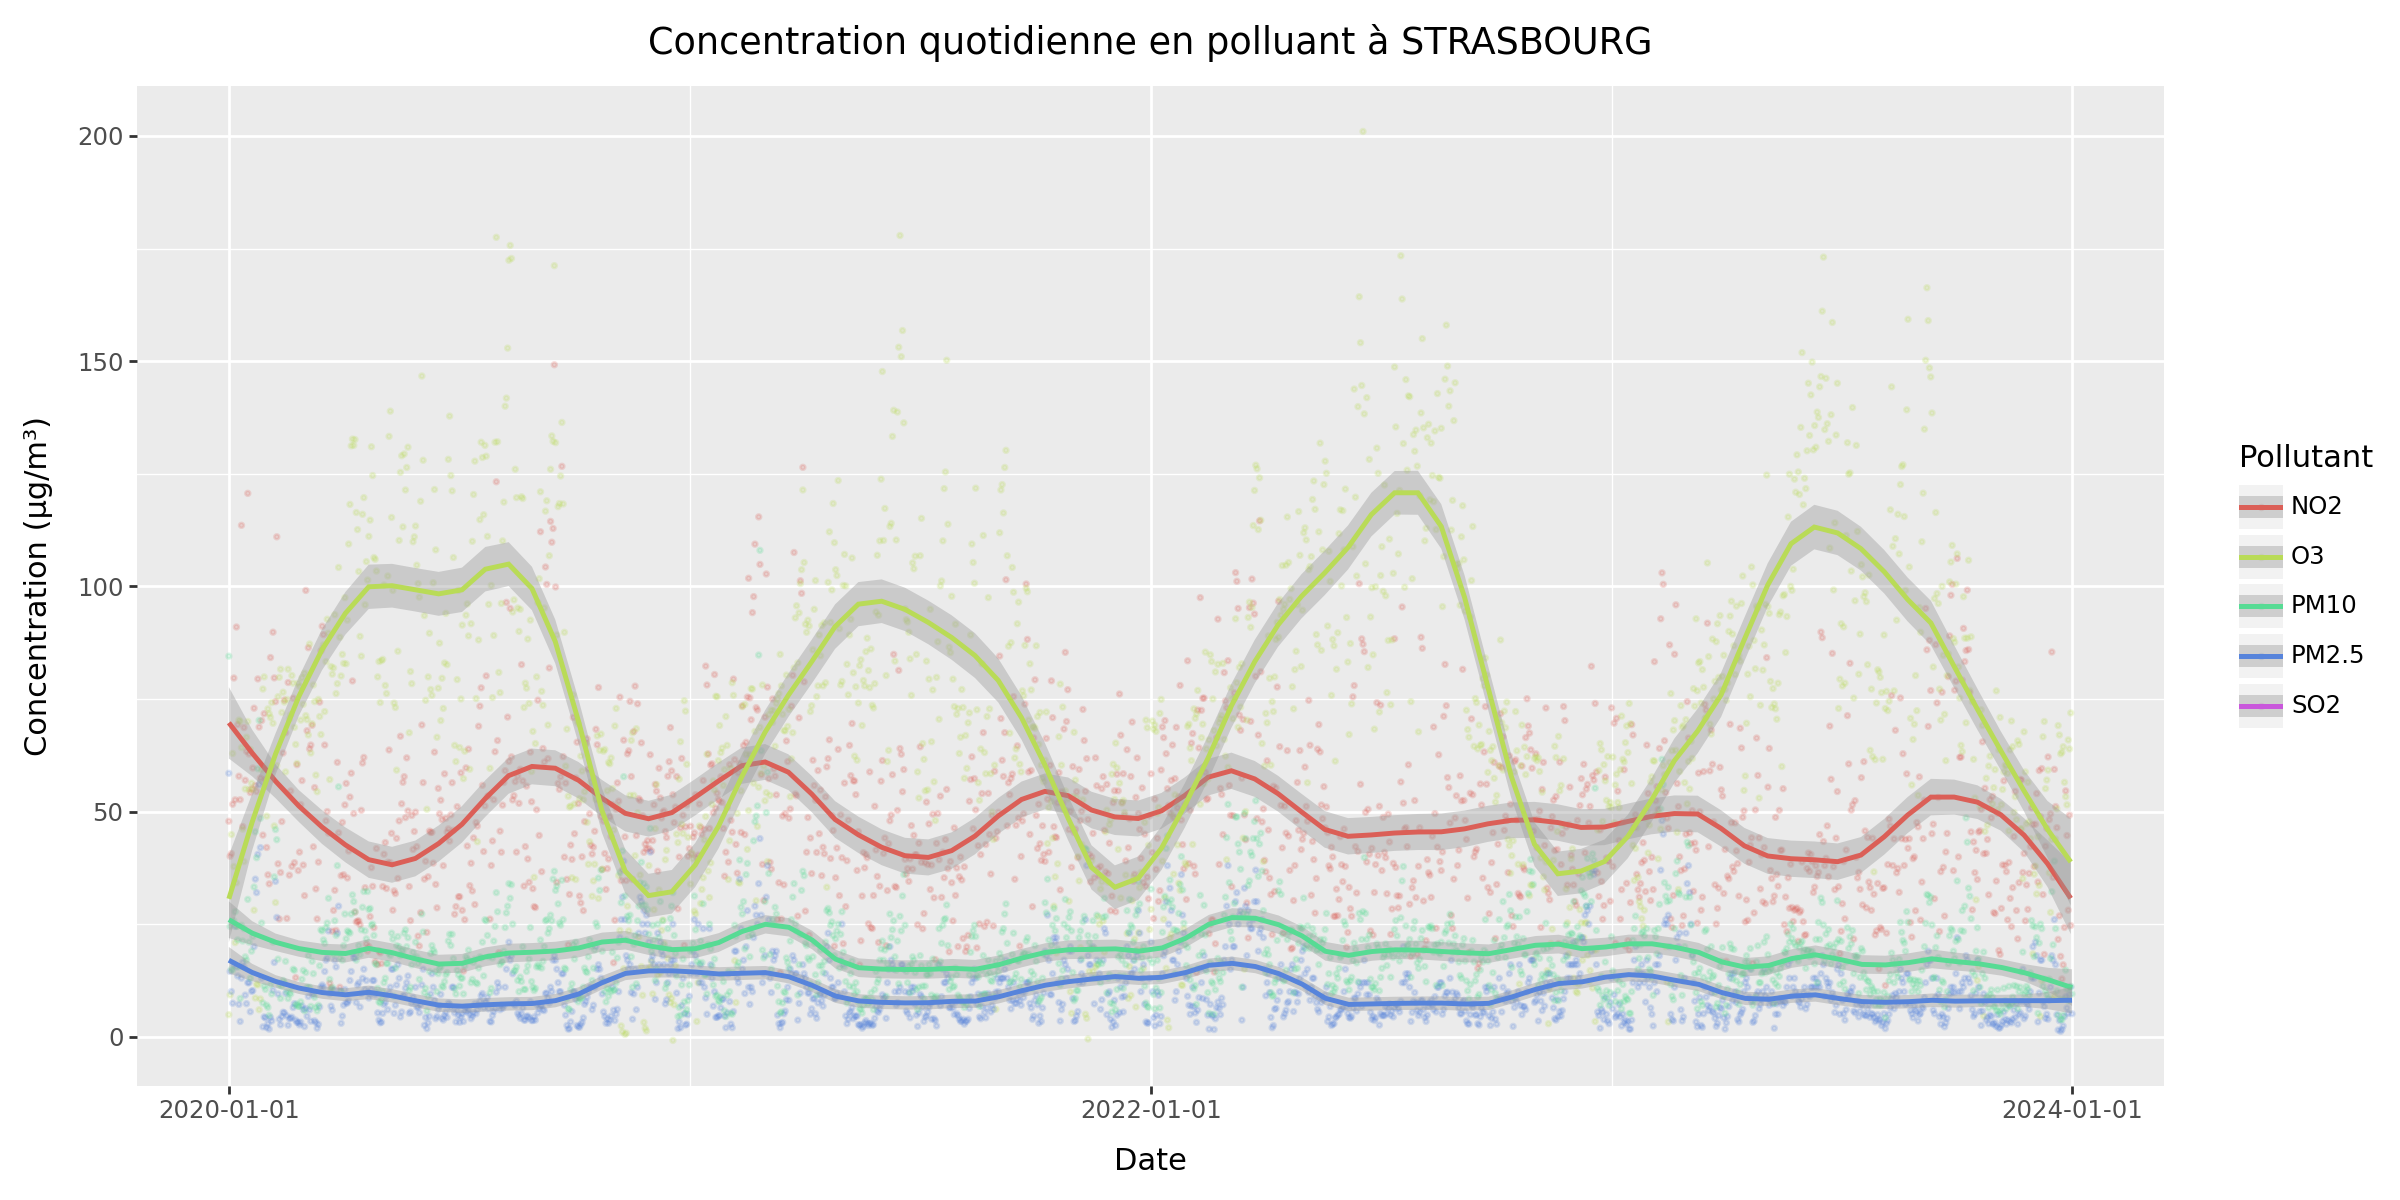

In [23]:
from plotnine import ggplot, aes, geom_point, geom_smooth, theme_minimal, labs, theme



def plot_pollutants_ggplot(df, smoothing = 0.15):
    '''
    Cette fonction réalise un plot des séries temporelles correspondant aux polluants, par ville et en utilisant ggplot2.
    '''
    warnings.simplefilter("ignore")
    # On Melt le dataframe pour simplifier le plotting avec plotnine
    melted_df = df.melt(id_vars='date',
                        value_vars=['NO2', 'O3', 'PM2.5', 'PM10', 'SO2'],
                        var_name='Polluant',
                        value_name='Concentration')
    
    ville = str(df[['nom_m']].iloc[0,0])

    # On crée ggplot
    p = (ggplot(melted_df, aes(x='date', y='Concentration', color='Polluant'))
         + geom_point(alpha=0.2, size=0.5)  # Points
         + geom_smooth(method='loess', span = smoothing,se=True, size=1)  # Smoothed lines
         + labs(title=f'Concentration quotidienne en polluant à {ville}',
                x='Date',
                y='Concentration (µg/m³)',
                color='Pollutant')
         + theme(figure_size=(12, 6))                            
         )
         
    return p

#On peut alors visualiser nos séries temporelles
plot_pollutants_ggplot(Y_t[(Y_t['nom_m'] == 'STRASBOURG')])



Un deuxième et troisième exemple avec Paris et Perpignan

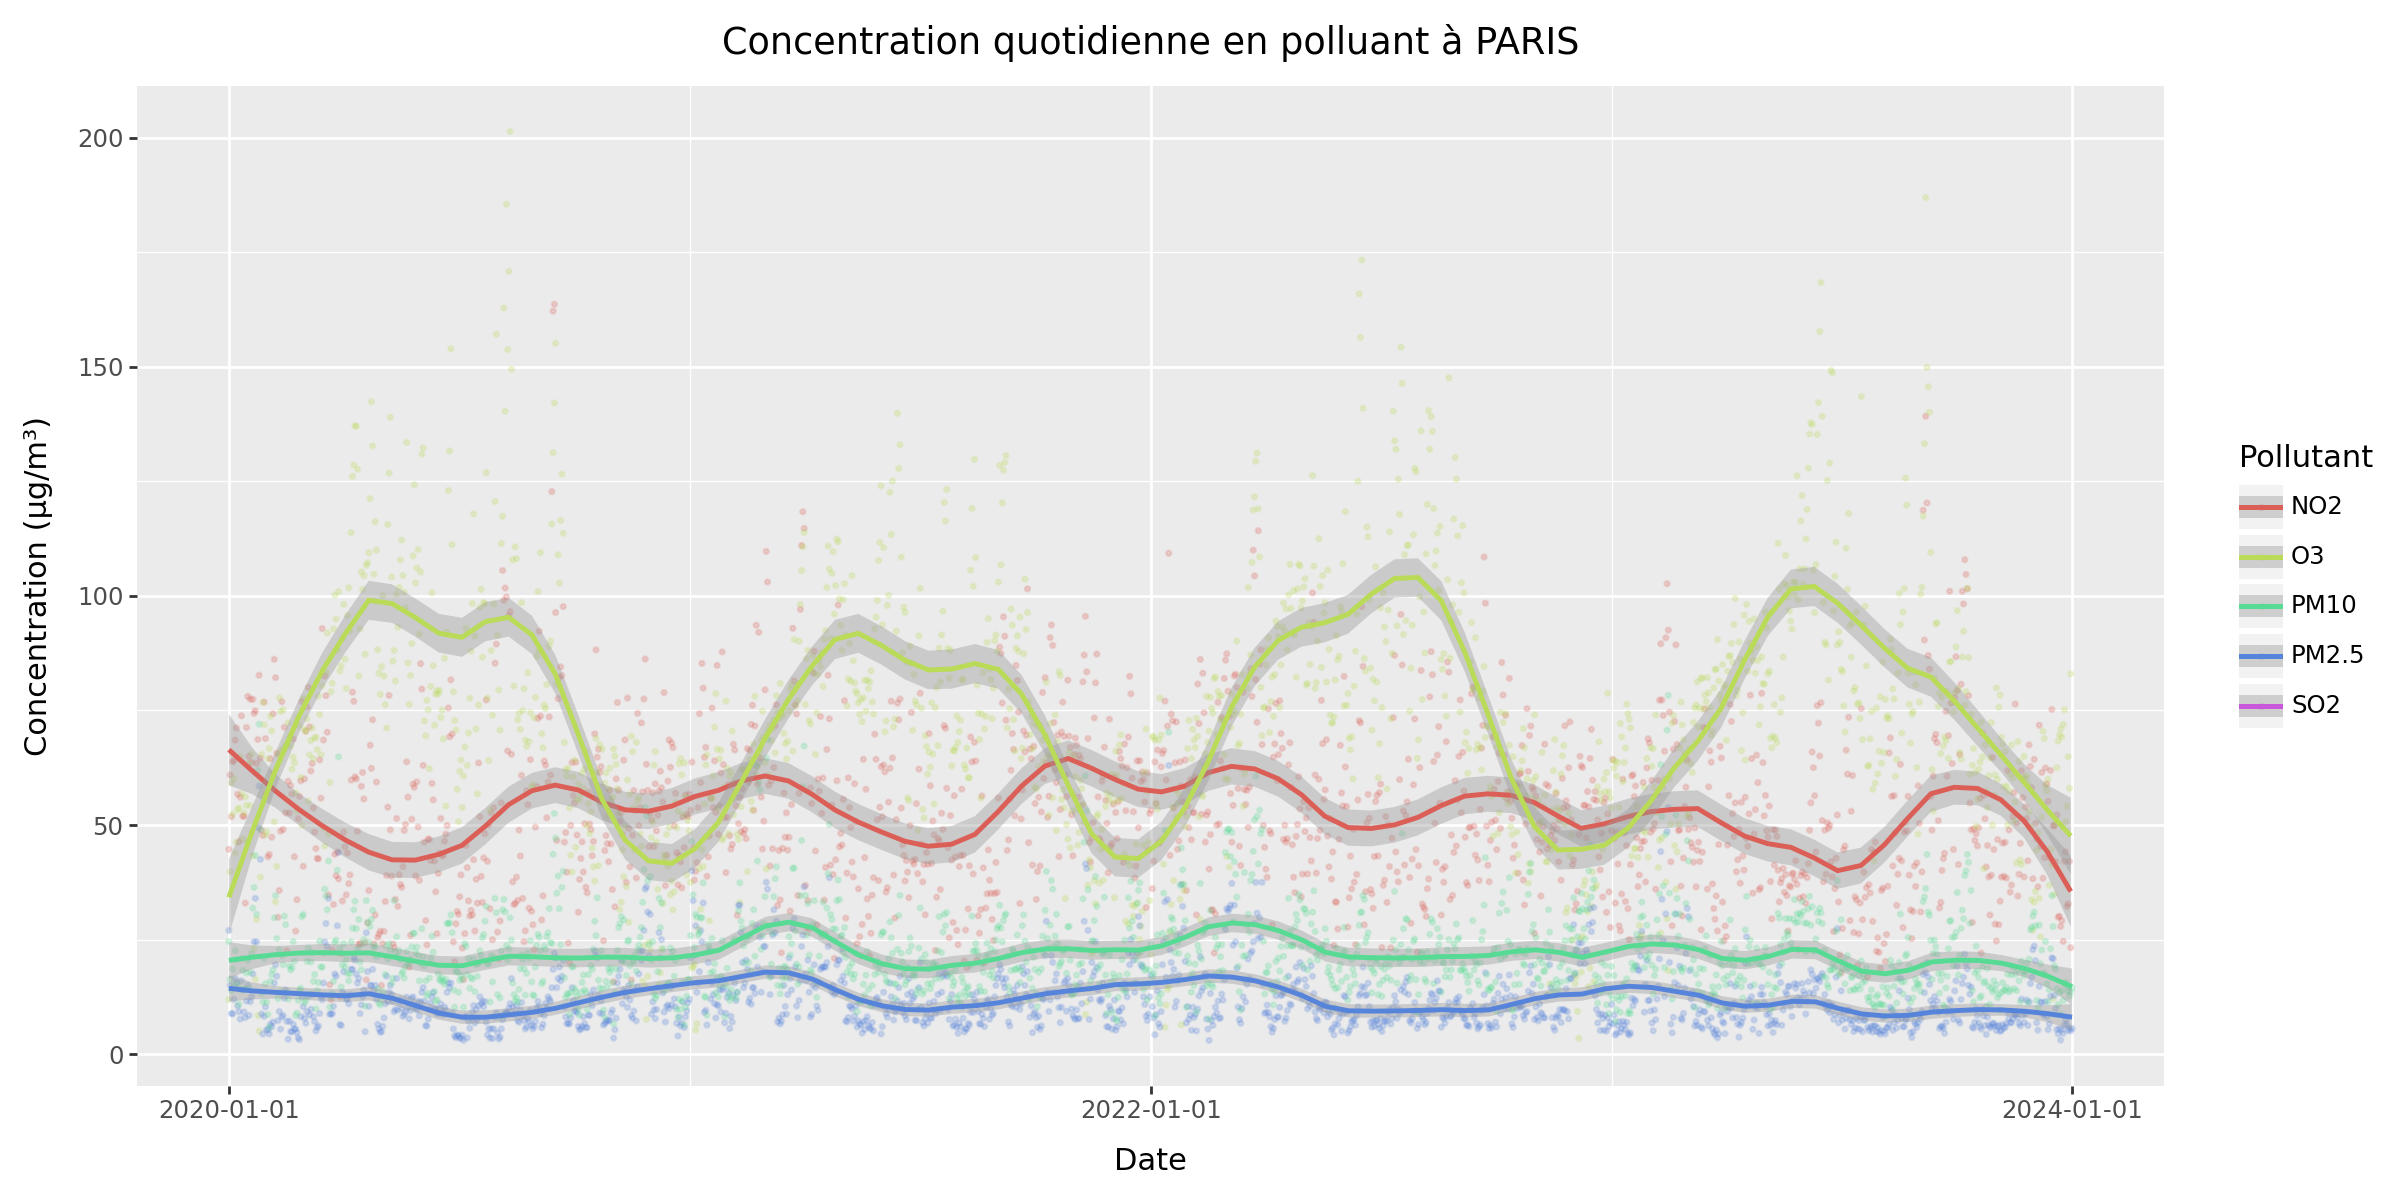

In [24]:
plot_pollutants_ggplot(Y_t[(Y_t['nom_m'] == 'PARIS')])

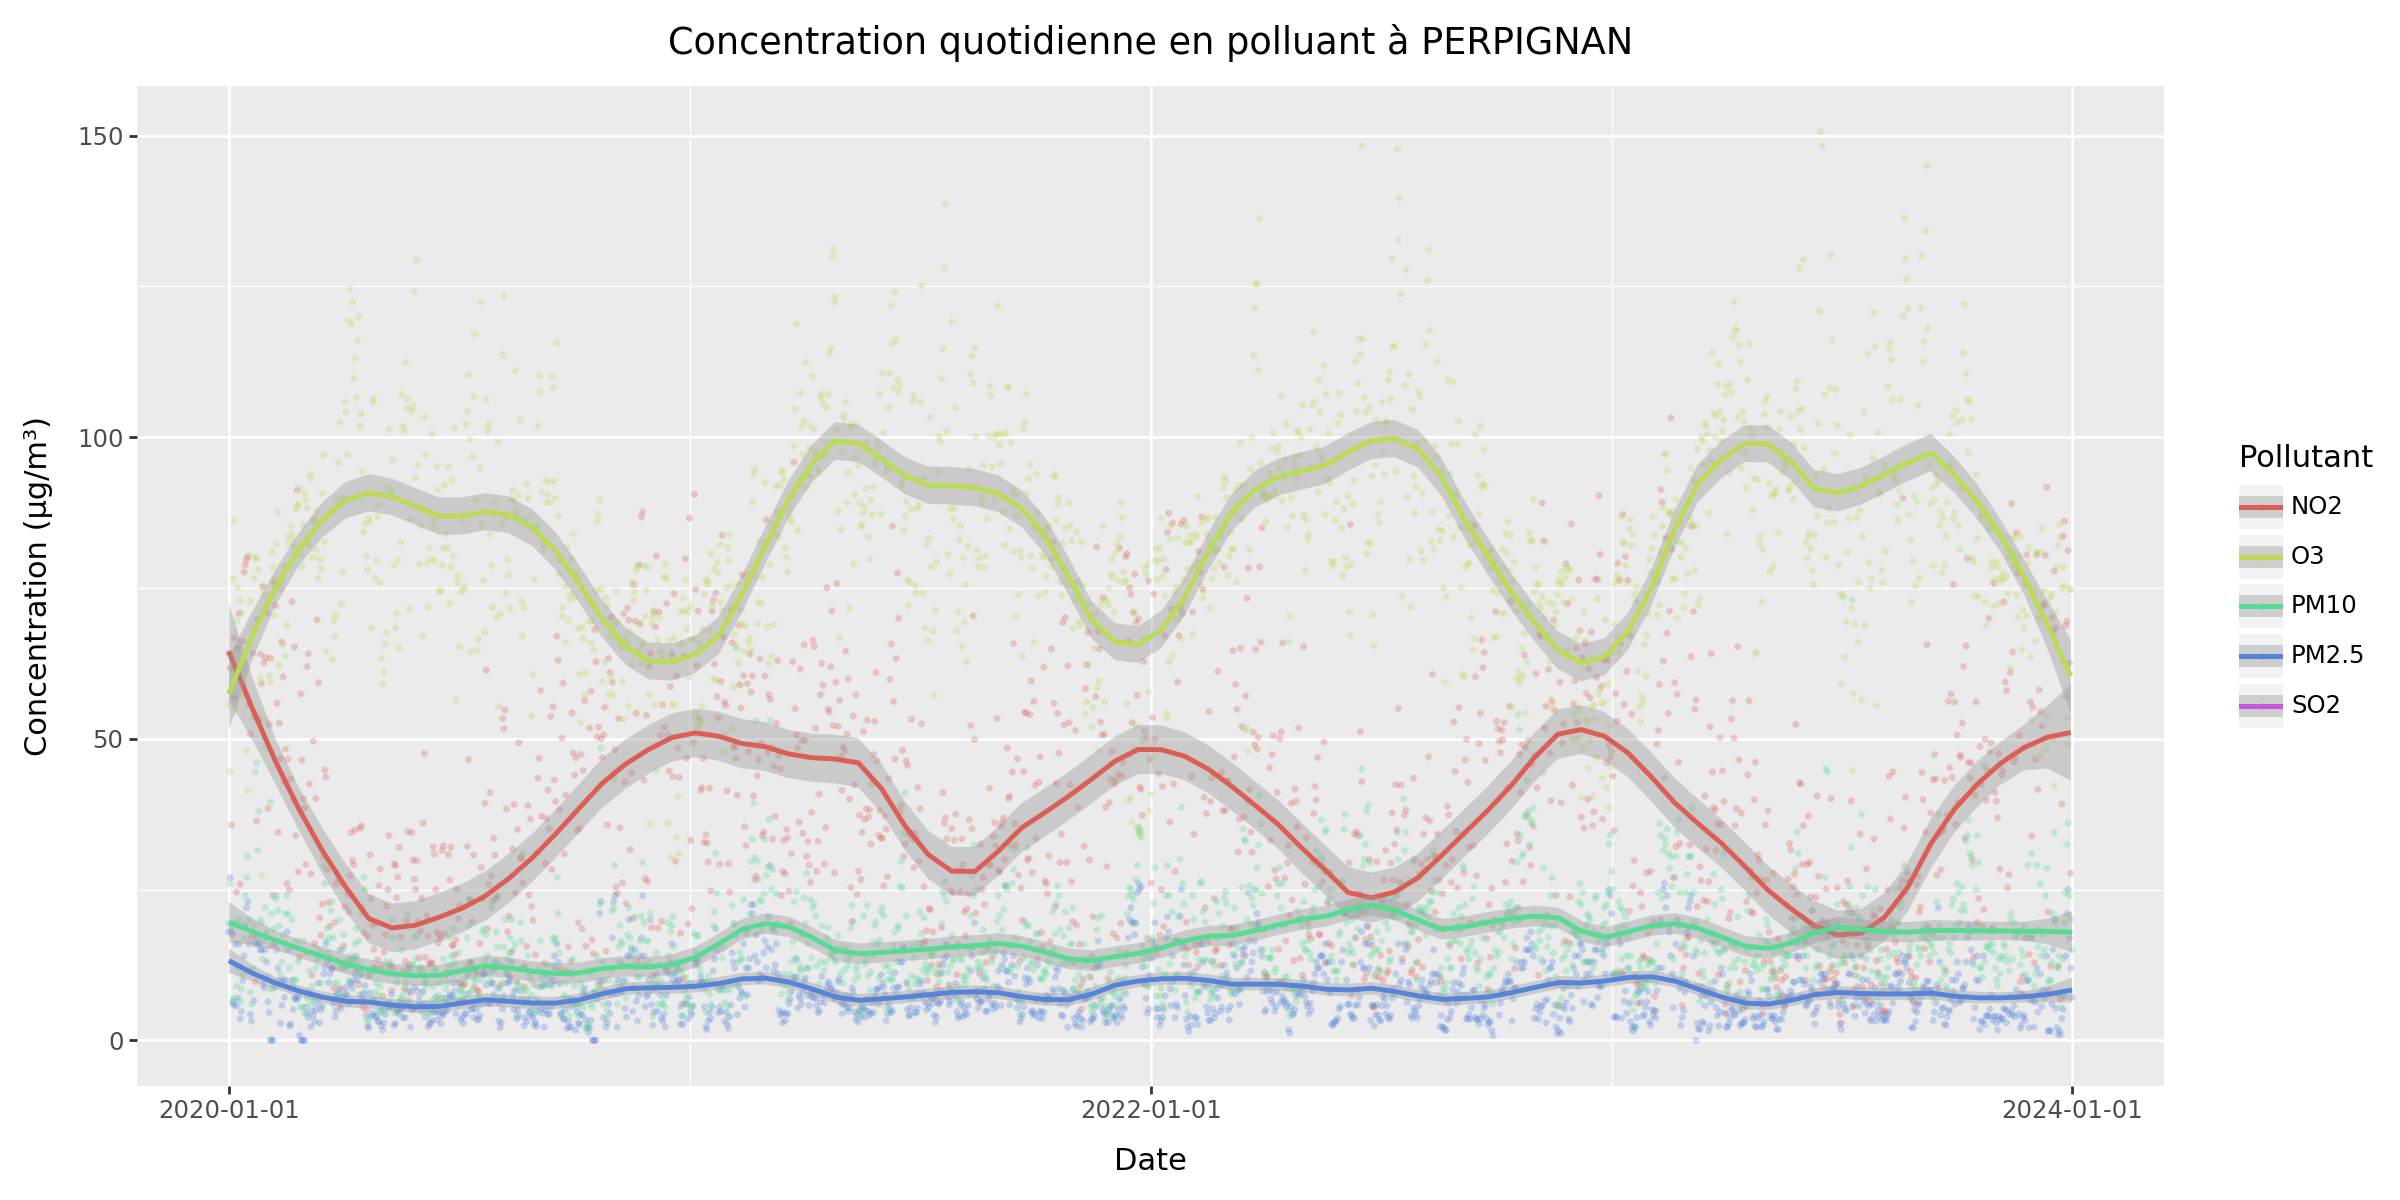

In [25]:
plot_pollutants_ggplot(Y_t[(Y_t['nom_m'] == 'PERPIGNAN')])

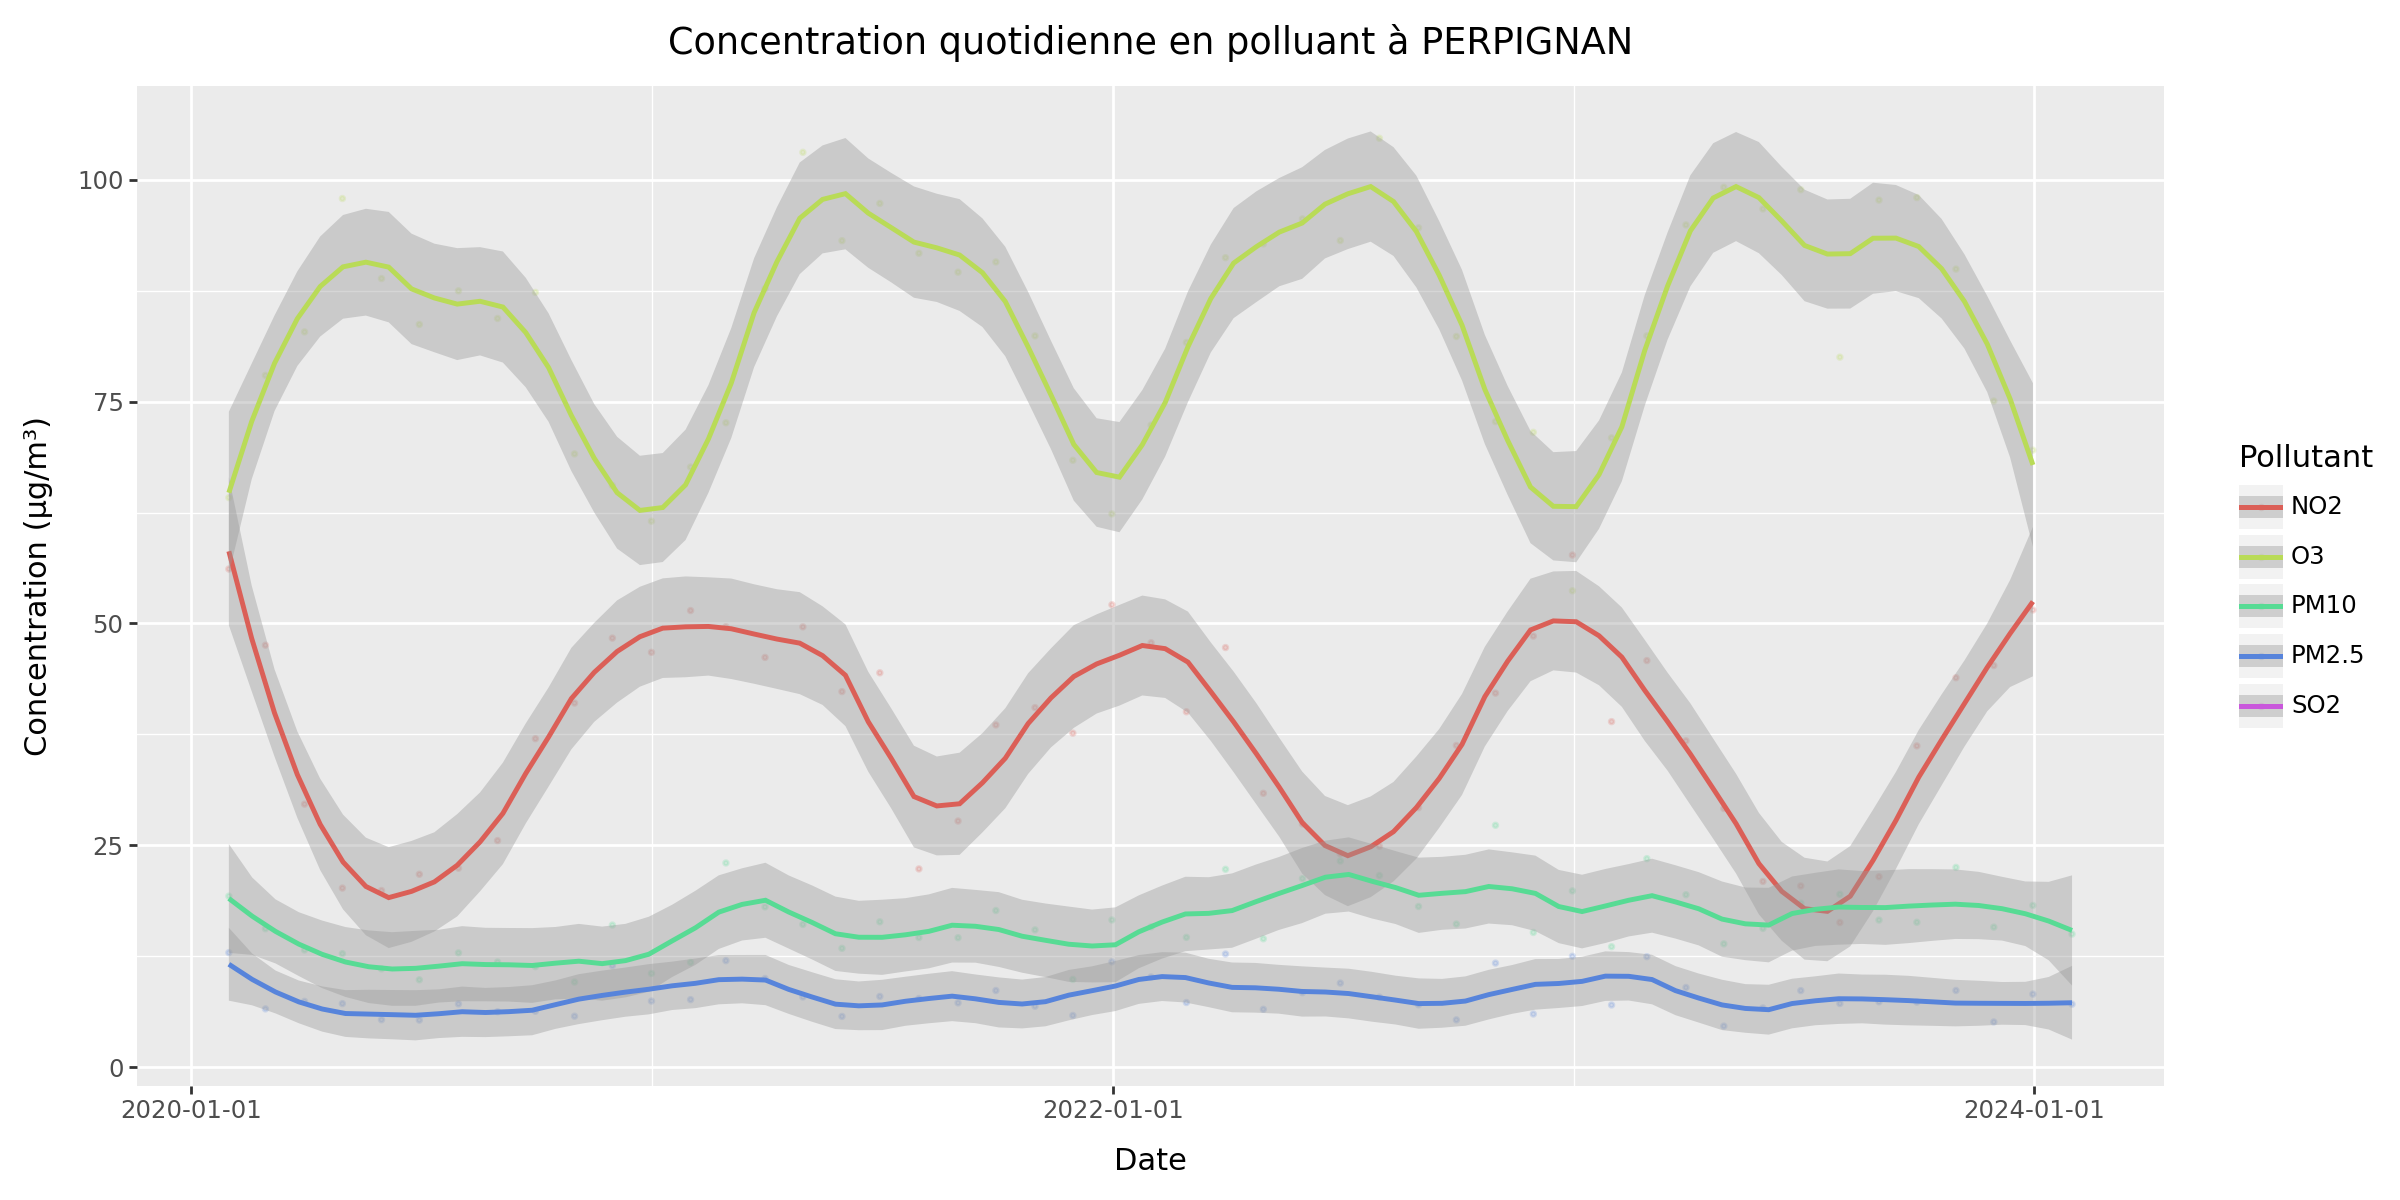

In [26]:
# Pourl'analyse, on sera obligé de simplifier les données en les aggrégeant par moyenne mensuelles.
#Cela donne donc
ville = 'PERPIGNAN'
data = Y_t[(Y_t['nom_m'] == ville)]
data.set_index('date', inplace=True)
monthly_data = data.resample('ME').mean(numeric_only=True)
monthly_data.reset_index(inplace=True)

monthly_data['nom_m'] = ville
plot_pollutants_ggplot(monthly_data, smoothing=0.2)

**Remarque :** Les séries temporelles ne semblent être caractérisée de 2 manières:
* Saisonnalité
* Absence de tendence claire
Cela nous conduit à favoriser les modèles de types $ARIMA(p,0,q)\times (P,0,Q,12)$ (soit des modèles ARIMA saisonniers sans tendances).\n
Nous ajoutons à cela le un facteur explicatif X ce qui nous donne donc SARIMAX!\n
L'équation d'un tel modèle serait :\n

$$y_t = \beta x_t + u_t$$

$$\phi_p(L)\tilde{\phi}_P(L^s)\Delta^d \Delta_s^D u_t = A(t) + \theta_q(L)\tilde{\theta}_Q(L^s)\varepsilon_t$$


- $ \phi_p(L) $ est le polynôme autoregressif non saisonnier ;
- $ \tilde{\phi}_P(L^s) $ est le polynôme autoregressif saisonnier ;
- $ \Delta^d \Delta_s^D y_t $ est la série temporelle, différenciée $d$ fois et différenciée $D$ fois de manière saisonnière ;
- $ A(t) $ est le polynôme de tendance (incluant l'intercept) ;
- $ \theta_q(L) $ est le polynôme de moyenne mobile non saisonnier ;
- $ \tilde{\theta}_Q(L^s) $ est le polynôme de moyenne mobile saisonnier.

La première équation est une simple régression linéaire, et la deuxième décrit le processus suivi par la composante d'erreur $u_t$ comme un SARIMA (tel que décrit dans l'exemple 3).  

In [32]:
import warnings

def eval_model(endog, exog = None, P = 3, Q = 3):
  '''Une fonction pour évaluer les modèles SARIMAX'''

  models = pd.DataFrame(np.zeros((D,2), dtype=float), columns = ['AIC','Model'])
  warnings.simplefilter('ignore')
  # Itération des modèles ARMA(p,0,q)
  aic = pd.DataFrame(np.zeros((P,Q), dtype=float))
  aic.iloc[0,0] = np.nan
  for p in range(P):
    for q in range(Q):
      if p == 0 and q == 0:
        continue

      # Estimation de chaque model
      mod = sm.tsa.statespace.SARIMAX(endog,exog, order=(p,0,q), enforce_invertibility=False)
      try:
        res = mod.fit(disp=False)
        # On choisit le critère d'information bayesien pour pénaliser plus la complexité des modèles
        aic.iloc[p,q] = res.bic
        print(f'Estimation du modèle ({p},0,{q} réussie')
      except:
        aic.iloc[p,q] = np.nan
        print(f'Estimation du modèle ({p},0,{q} échouée')

      models['AIC'] = aic.min().min()
      coord_min = aic.stack().idxmin()
      models['Model'] = str(coord_min[0])+str(0) + str(coord_min[1])
  return models

def select_model(endog, exog, P = 3, Q = 3):
  '''Une fonction pour sélectionner le meilleur modèle SARIMAX'''
  df_eval = eval_model(endog, exog,P,Q)
  best_model = df_eval['Model'][df_eval['AIC'].idxmin()]
  return best_model

# Ces fonctions sont optimisées grâce à ChatGPT, la différence en terme de rapidité d'exécution n'est pas très impressionnante (0.4 sec pour Perpignan)
from itertools import product
def eval_model_optimized(endog, exog=None, P=3, Q=3, D=3):
    """
    Evaluate SARIMAX models with optimized looping and memory usage.
    """
    warnings.simplefilter("ignore")
    
    # Prepare grid of parameters
    param_grid = list(product(range(P), range(D), range(Q)))
    results = []

    for p, d, q in param_grid:
        if p == 0 and q == 0:
            results.append((np.nan, f"{p}{d}{q}"))

        try:
            # Fit SARIMAX model
            mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(p, d, q), enforce_invertibility=False)
            res = mod.fit(disp=False)

            # Store results
            results.append((res.bic, f"{p}{d}{q}"))
        except:
            # If the model fails, store NaN
            results.append((np.nan, f"{p}{d}{q}"))

    # Convert to DataFrame
    results_df = pd.DataFrame(results, columns=["AIC", "Model"])
    return results_df

def select_model_optimized(endog, exog=None, P=3, Q=3, D=3):
    """
    Select the best SARIMAX model based on BIC.
    """
    eval_df = eval_model_optimized(endog, exog, P, Q, D)
    best_model = eval_df["Model"].iloc[eval_df["AIC"].idxmin()]
    return tuple(int(char) for char in best_model)


In [ ]:
# On regroupe par donées mensuells
ville = 'PERPIGNAN'
data = Y_t[(Y_t['nom_m'] == ville)]
data.set_index('date', inplace=True)
monthly_data = data.resample('ME').mean(numeric_only=True)
monthly_data.reset_index(inplace=True)
# Exemple : Chargement des données environnementales
# Remplacez cela par votre dataset réel
data = monthly_data

data.set_index('date', inplace=True)

# Définir la fréquence journalière
data.index.freq = 'M'

# Vérifiez votre colonne cible (par ex., 'NO2')
target_variable = 'NO2'

# Diviser les données en train/test si nécessaire
train = data[target_variable].loc[:'2022-12-31']

test = data[target_variable].loc['2023-01-01':]
'''
# Configurer et ajuster le modèle SARIMAX (saisonnier)
model = sm.tsa.statespace.SARIMAX(train, 
                order=(0, 2, 1),  # p, d, q
                seasonal_order=(1, 0, 0, 12),  # P, D, Q, S (S = saisonnalité annuelle pour les données journalières)
                enforce_stationarity=False, 
                enforce_invertibility=False)
'''
# Modèle non saisonnier
model = sm.tsa.statespace.SARIMAX(train, 
                order=(2, 1, 3),  # p, d, q
                enforce_stationarity=False, 
                enforce_invertibility=False)

results = model.fit(disp=False)

# Résumé du modèle
print(results.summary())


date
2020-01-31    56.135484
2020-02-29    47.548276
2020-03-31    29.637097
2020-04-30    20.185000
2020-05-31    19.909677
2020-06-30    21.740000
2020-07-31    22.420968
2020-08-31    25.533871
2020-09-30    37.016667
2020-10-31    41.029032
2020-11-30    48.351667
2020-12-31    46.745161
2021-01-31    51.452688
2021-02-28    49.633333
2021-03-31    46.171505
2021-04-30    49.617222
2021-05-31    42.322581
2021-06-30    44.439444
2021-07-31    22.341935
2021-08-31    27.738710
2021-09-30    38.563333
2021-10-31    40.519355
2021-11-30    37.640000
2021-12-31    52.106452
2022-01-31    47.822581
2022-02-28    40.050000
2022-03-31    47.283871
2022-04-30    30.863333
2022-05-31    27.400000
2022-06-30    24.045833
2022-07-31    24.893333
2022-08-31    29.238710
2022-09-30    36.255172
2022-10-31    42.148387
2022-11-30    48.573333
2022-12-31    57.706452
Freq: ME, Name: NO2, dtype: float64

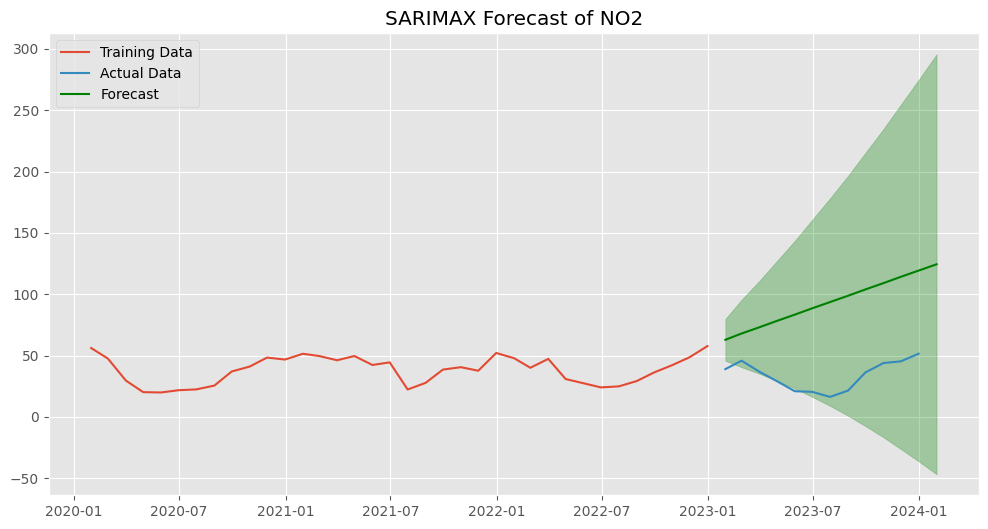

In [98]:
# Faire des prédictions
forecast = results.get_forecast(steps=len(test))
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data')
plt.plot(forecast.predicted_mean, label='Forecast', color='green')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='green', alpha=0.3)
plt.legend()
plt.title(f'SARIMAX Forecast of {target_variable}')
plt.show()



In [102]:
# ON va essayer de voir quel modèle est le plus efficae (minimisation de AIC)
p = 6
q = 6
d = 3
print(eval_model(train,P = p,Q = q,D = d))
#print(select_model(train,P = p,Q = q,D = d))
#Le modèle réusltant pour Perpignan (asn compter la partie exogène X_t est (0,2,1))
# Nous n'avons pas la capacité computationnelles de produire une modèle saisonnier


          AIC Model
0  263.865157   100
1  252.658259   213
2  250.274576   021


In [137]:
# On va maintenant ajouter les données exogènes (sur X_t):
# On regroupe par donées mensuells
'''
ville = 'PERPIGNAN'
data = Y_t[(Y_t['nom_m'] == ville)]
data.set_index('date', inplace=True)
monthly_data = data.resample('ME').mean(numeric_only=True)
monthly_data.reset_index(inplace=True)
# Exemple : Chargement des données environnementales
'''
def arima_mensuel(df, ville):
    '''Une fonction qui transforme les données quotidiennes en données mensuelles, utilisatble pour ARIMA
        ville doit être entré en MAJUSCULES entre guillemets, exemple : vers_mensuel(Y_t, 'PERPIGNAN')
    '''
    data = df[df['nom_m']==ville]
    data.set_index('date', inplace = True)
    data_mensuel = data.resample('ME').mean(numeric_only=True)
    data_mensuel.reset_index(inplace=True)
    data_mensuel.index.freq = 'M'
    data_mensuel.set_index('date', inplace=True)
    return data_mensuel

target_variable = 'NO2'
exog_variables = ['pression_niveau_mer_Pa',
    'var_pression_3h_Pa',
    'direction_vent_moyen_10mn_deg',
    'vitesse_vent_moyen_10mn_m/s',
    'temperature_K',
    'humidite_%',
    'visibilite_horizontale_m',
    'precipitations_24h_mm'
    ]

exog_data =arima_mensuel(X_t, 'PERPIGNAN').loc[:, exog_variables].dropna() 
exog = sm.add_constant(exog_data)
endog = arima_mensuel(Y_t, 'PERPIGNAN').loc[exog_data.index,target_variable]
# Modèle non saisonnier
model = sm.tsa.SARIMAX(endog, exog,
                order=(1, 0, 1),  # p, d, q
                seasonal_order = (1,0,2,12),
                enforce_stationarity=False, 
                enforce_invertibility=False)

results = model.fit(maxiter=500, regularized = True)

# Résumé du modèle
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                     NO2   No. Observations:                   48
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 -62.634
Date:                                 Wed, 25 Dec 2024   AIC                            155.269
Time:                                         12:20:14   BIC                            171.635
Sample:                                     01-31-2020   HQIC                           159.124
                                          - 12-31-2023                                         
Covariance Type:                                   opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           223.

In [ ]:
import scipy.stats as stats

residuals = results.resid
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002401737BA10>>
Traceback (most recent call last):
  File "C:\Users\antoi\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 785, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1494, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


<Figure size 1200x600 with 0 Axes>

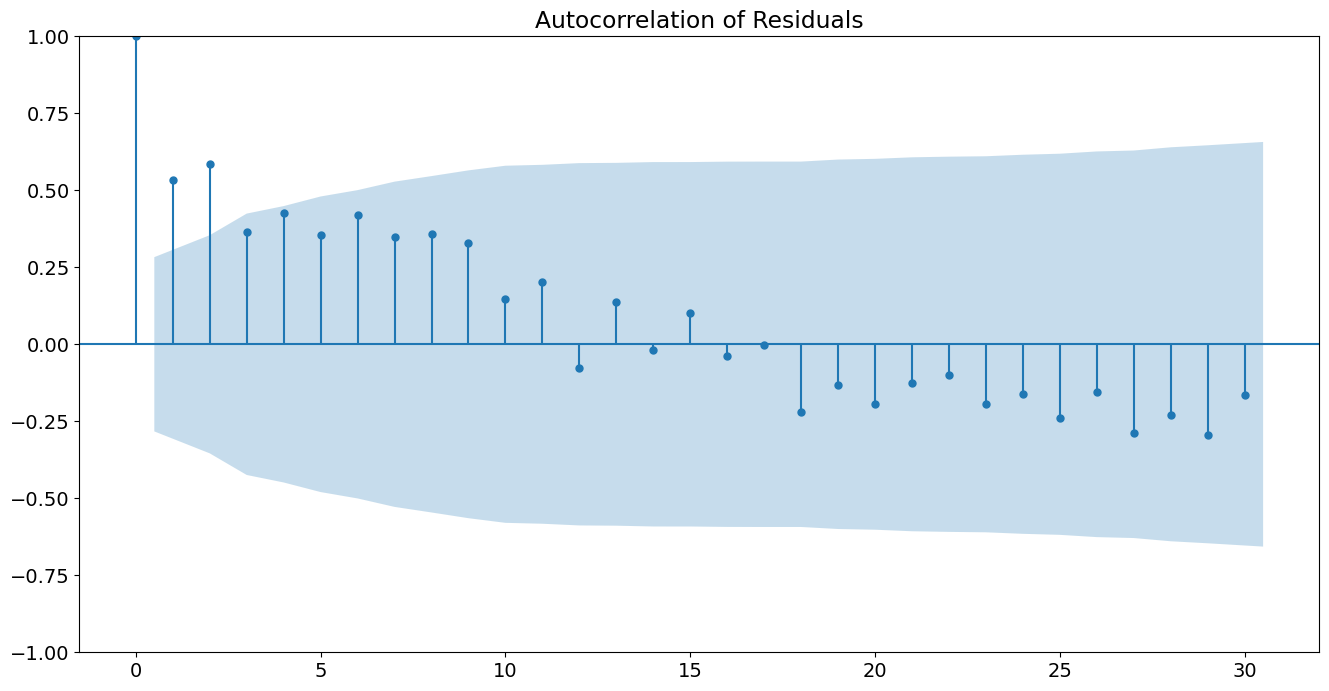

<Figure size 1200x600 with 0 Axes>

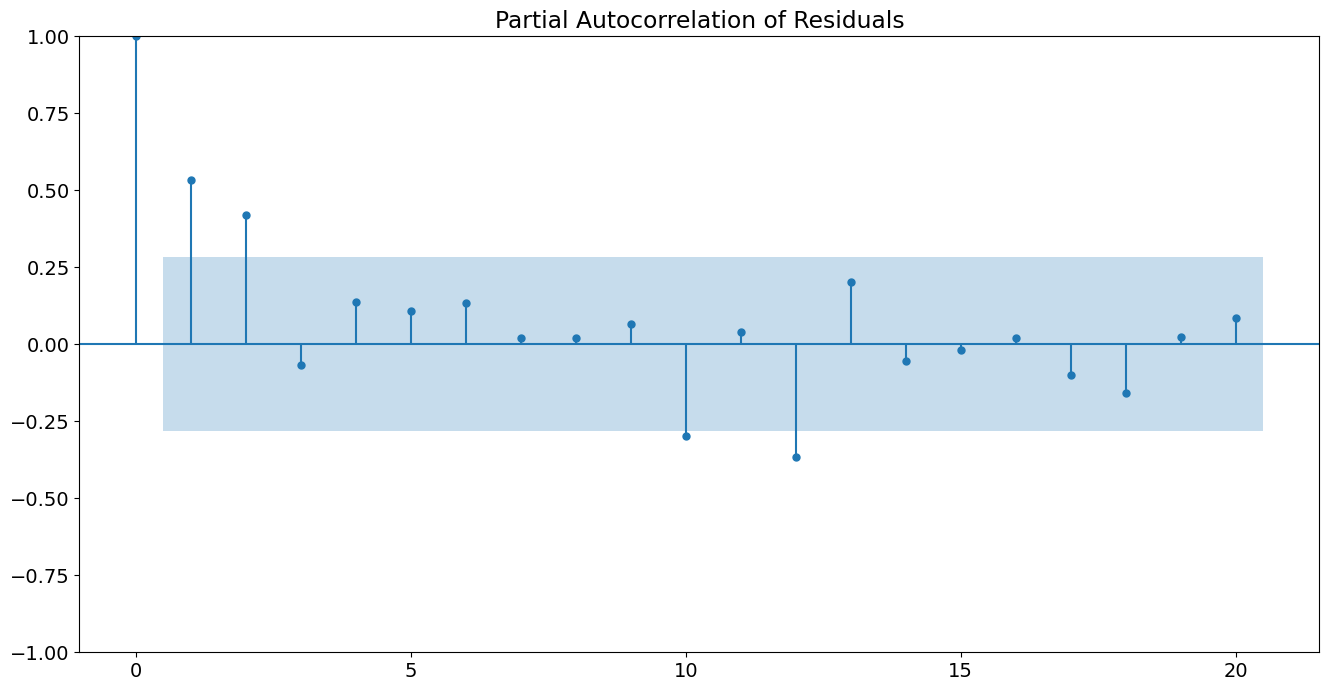

In [124]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=30)
plt.title('Autocorrelation of Residuals')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(residuals, lags=20)
plt.title('Partial Autocorrelation of Residuals')
plt.show()

In [116]:
# Calcul de la matrice de covariance
cov_matrix = np.cov(residuals, bias=False)

print("Matrice de covariance :\n", cov_matrix)

Matrice de covariance :
 51.730794979363246


Le test ADf permet de tester la stationnarité d'une série temporelle.\
On a $H_0$ : "La série est non-stationnaire" vs. $H_1$ : "La série est stationnaire"\

Ici on a :\
Statistique ADf = -5.421\
p-valeur = 0.00000306

On rejette donc $H_0$ la série temporelle est stationnaire

In [89]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(endog, autolag='AIC')
print(f'ADF Statistic: {adf[0]}')
print(f'n_lags: {adf[1]}')
print(f'p-value: {adf[1]}')
for key, value in adf[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 



ADF Statistic: -5.421269349819748
n_lags: 3.0556555353073916e-06
p-value: 3.0556555353073916e-06
Critial Values:
   1%, -3.5925042342183704
Critial Values:
   5%, -2.931549768951162
Critial Values:
   10%, -2.60406594375338


Automatisation de la démarche

In [28]:
# Filter the dataframe for entries with 'population' > 10000
filtered_Y_t = Y_t[Y_t['population'] > 10000]

# Randomly sample 3 unique values of 'nom_m' from the filtered dataframe
sampled_nom_m = filtered_Y_t['nom_m'].drop_duplicates().sample(n=3, random_state=42)

# Subset the original dataframe to include only the sampled 'nom_m' time series
Y_t_sample = Y_t[Y_t['nom_m'].isin(sampled_nom_m)]

# Reset the index for the sampled dataframe
Y_t_sample.reset_index(drop=True, inplace=True)

Y_t_sample

,index,date,nom_m,NO2,O3,PM2.5,PM10,SO2,population
0,11681,2020-01-01,ANGERS,25.90,52.4,16.0,18.0,NaN,157175
1,11682,2020-01-02,ANGERS,26.50,61.1,9.3,14.0,NaN,157175
2,11683,2020-01-03,ANGERS,23.90,70.8,6.9,12.0,NaN,157175
3,11684,2020-01-04,ANGERS,68.35,73.1,13.0,21.0,NaN,157175
4,11685,2020-01-05,ANGERS,40.55,75.7,11.0,14.0,NaN,157175
...,...,...,...,...,...,...,...,...,...
4380,396207,2023-12-28,PORT-JEROME-SUR-SEINE,35.20,NaN,NaN,18.0,151.1,10387
4381,396208,2023-12-29,PORT-JEROME-SUR-SEINE,27.80,NaN,NaN,13.0,166.4,10387
4382,396209,2023-12-30,PORT-JEROME-SUR-SEINE,19.50,NaN,NaN,9.0,95.6,10387
4383,396210,2023-12-31,PORT-JEROME-SUR-SEINE,27.60,NaN,NaN,9.0,95.1,10387


In [ ]:
from statistics import mode


target_variable = 'NO2'
exog_variables = ['pression_niveau_mer_Pa',
    'var_pression_3h_Pa',
    'direction_vent_moyen_10mn_deg',
    'vitesse_vent_moyen_10mn_m/s',
    'temperature_K',
    'humidite_%',
    'visibilite_horizontale_m',
    'precipitations_24h_mm'
    ]

exog_data =arima_mensuel(X_t, ville).loc[:, exog_variables].dropna() 
exog = sm.add_constant(exog_data)
endog = arima_mensuel(Y_t, ville).loc[exog_data.index,target_variable]

for ville in list(Y_t_sample['nom_m']):
    #Set pour gagner en vitesse d'exécution
    set_hyp_param = []

    #On calcule le modèle optimal pour l'échantillon de villes
    exog_data =arima_mensuel(X_t, ville).loc[:, exog_variables].dropna() 
    exog = sm.add_constant(exog_data)
    endog = arima_mensuel(Y_t, ville).loc[exog_data.index,target_variable]
    set_hyp_param.append(select_model_optimized(endog = endog,exog =  exog, P = 5, Q = 5, D = 3))
    result = mode(set_hyp_param)

result


In [52]:

ville = 'PERPIGNAN'
polluant = 'NO2'

def resultat_arimax(Y,X = None, polluant ='NO2', ville = 'STRASBOURG'):
    '''
    Cette fonction calcule les coefficiens ARIMA sachant les paramètres du modèles donnés.
    Elle revoit un dataframe contenant les valeurs estimées du modèles (coefficients et p-valeurs)
    '''

    warnings.simplefilter("ignore")

    exog_variables = ['pression_niveau_mer_Pa',
                      'var_pression_3h_Pa',
                      'direction_vent_moyen_10mn_deg',
                      'vitesse_vent_moyen_10mn_m/s',
                      'temperature_K',
                      'humidite_%',
                      'visibilite_horizontale_m',
                      'precipitations_24h_mm'
                    ]

    # On traite les données exogènes
    exog_data =arima_mensuel(X, ville).loc[:, exog_variables].dropna()

    # On traite les données endogènes
    exog = sm.add_constant(exog_data)

    # On aligne les indice de endog et exog 
    endog = arima_mensuel(Y, ville).loc[exog_data.index,polluant]    

    # Modèle non saisonnier
    model = sm.tsa.statespace.SARIMAX(endog, exog,
                    order=(1, 0, 2),  # p, d, q
                    seasonal_order = (1,0,1,12),
                    enforce_stationarity=False, 
                    enforce_invertibility=False)

    results = model.fit(maxiter = 500, disp=False)
    return pd.DataFrame({
        'nom_m':ville, 
        'polluant':polluant,
        'coefficiens' : results.params,
        'p-valeurs' : results.pvalues
        })

def get_hyper_param_liste(Y,X):
    '''
    Cette fonction permet d'obtenir les paramètres optimaux pour la sélection du modèle arima pour chaque polluant
    Dans l'ordre: 'NO2','O3','PM2.5','PM10'.
    '''
    hyper_param_liste = []
    return hyper_param_liste

def arima_tout_polluants(Y,X, ville):
    '''
    Cette fonction renvoie un dataframe contenant les résultat de l'estimation ARIMAX pour les paramètres spécifiés du modèle
    L'argument 'hyper_param_list' est une liste contenant les tuples correspondant aux hyperparamètres optimaux pour chaques polluant 
    (dans l'ordre : 'NO2','O3','PM2.5','PM10').
    '''
    polluant = ['NO2','O3','PM2.5','PM10']
    liste_arima_resultats = [
        resultat_arimax(Y,X,polluant=polluant[i], ville = ville)
        for i in range(4)
    ]
    output = pd.concat(liste_arima_resultats)
    return output
#Cette fonction fonctionne bien

def modelisation_arima(Y,X):
    '''
    Cette fonction calcule les coefficients et p-valeurs pour chaque les villes du jeu dont la population est supérieure à pop_min (int)
    Elle renvoie le résultat sous forme de dataframe
    '''
    
    liste_arima_resultat_ville = [arima_tout_polluants( Y,X,ville) for ville in list(Y['nom_m'])]
    output = pd.concat(liste_arima_resultat_ville)
    return output

#modelisation_arima(Y_t_sample,X_t)

'''
modelisations = []
for ville in ['PARIS','STRASBOURG','PERPIGNAN']:
    try :
        modelisations.append(resultat_arimax(Y_t,X_t, polluant='NO2',ville = ville))
        print(f"Le modèle a été calculé pour {ville}")
    except:
        print(f"Le modèle n'a pas pu être calculé pour {ville}")
resultat = pd.concat(modelisations)
resultat.reset_index(inplace = True)
resultat.rename(columns={'index':'parametre'}, inplace=True)
resultat = pd.pivot(resultat,index='nom_m',columns='parametre',values = ['coefficiens','p-valeurs'])
resultat
'''
resultat_arimax(Y_t,X_t,polluant='NO2',ville = ville)

,nom_m,polluant,coefficiens,p-valeurs
const,PERPIGNAN,NO2,2.237854e+02,0.000000
pression_niveau_mer_Pa,PERPIGNAN,NO2,3.585029e-03,0.000000
var_pression_3h_Pa,PERPIGNAN,NO2,2.965008e-02,0.000000
direction_vent_moyen_10mn_deg,PERPIGNAN,NO2,-9.294629e-03,0.000000
vitesse_vent_moyen_10mn_m/s,PERPIGNAN,NO2,-5.917187e+00,0.000000
temperature_K,PERPIGNAN,NO2,-1.810299e+00,0.000000
humidite_%,PERPIGNAN,NO2,-1.342249e-01,0.000000
visibilite_horizontale_m,PERPIGNAN,NO2,1.230979e-04,0.000000
precipitations_24h_mm,PERPIGNAN,NO2,-1.643639e+00,0.000000
ar.L1,PERPIGNAN,NO2,5.964135e-01,0.000000


In [34]:
import random

# On sélectionne les villes en France de plus de 100k hoabitants
Y_t_super_pop = Y_t[Y_t['population'] > 100000]
# Reset the index for the sampled dataframe
Y_t_super_pop.reset_index(drop=True, inplace=True)
# On sélectionne d'abord 15 parmis les 37 villes
villes_super_pop = random.sample(list(Y_t_super_pop['nom_m'].unique()),15)
villes_super_pop_all = list(Y_t_super_pop['nom_m'].unique())

# On procède à la modélisation
modelisations = []
for ville in villes_super_pop_all:
    try :
        modelisations.append(resultat_arimax(Y_t,X_t, polluant='NO2',ville = ville))
        print(f"Le modèle a été calculé pour {ville}")
    except:
        print(f"Le modèle n'a pas pu être calculé pour {ville}")
resultat = pd.concat(modelisations)
resultat.reset_index(inplace = True)
resultat.rename(columns={'index':'parametre'}, inplace=True)
resultat = pd.pivot(resultat,index='nom_m',columns='parametre',values = ['coefficiens','p-valeurs'])
resultat

Le modèle a été calculé pour AIX-EN-PROVENCE
Le modèle a été calculé pour AMIENS
Le modèle a été calculé pour ANGERS
Le modèle a été calculé pour ANNECY
Le modèle a été calculé pour ARGENTEUIL
Le modèle a été calculé pour BESANCON
Le modèle a été calculé pour BORDEAUX
Le modèle a été calculé pour BREST
Le modèle a été calculé pour CAEN
Le modèle a été calculé pour CLERMONT-FERRAND
Le modèle a été calculé pour DIJON
Le modèle a été calculé pour GRENOBLE
Le modèle a été calculé pour LE HAVRE
Le modèle a été calculé pour LE MANS
Le modèle a été calculé pour LILLE
Le modèle a été calculé pour LIMOGES
Le modèle a été calculé pour LYON
Le modèle a été calculé pour MARSEILLE
Le modèle a été calculé pour METZ
Le modèle a été calculé pour MONTPELLIER
Le modèle a été calculé pour MULHOUSE
Le modèle a été calculé pour NANCY
Le modèle a été calculé pour NANTES
Le modèle a été calculé pour NICE
Le modèle a été calculé pour NIMES
Le modèle a été calculé pour ORLEANS
Le modèle a été calculé pour PARI

coefficiens                         \
parametre              ar.L1  ar.S.L12        const   
nom_m                                                 
AIX-EN-PROVENCE     0.082021  0.031567 -1381.803224   
AMIENS              0.328176  0.296995   325.904345   
ANGERS              0.058751  0.490934   121.627264   
ANNECY             -0.000409  0.325347 -1364.320526   
ARGENTEUIL          0.102364 -0.413714   279.303254   
BESANCON            0.075454  0.681200  -484.694958   
BORDEAUX           -0.175375  0.490709  -578.158806   
BREST               0.244757  0.556577  -112.846842   
CAEN                0.661962  0.615032   190.608336   
CLERMONT-FERRAND   -0.788345  1.034785  -896.981389   
DIJON               0.111908  0.699406  -385.911985   
GRENOBLE            0.320466  0.486437 -1403.247254   
LE HAVRE            0.144180  1.094815    91.552398   
LE MANS             0.185890  0.664070   174.068215   
LILLE               0.075446 -0.024679  -303.083603   
LIMOGES            -0.082711  0.680614  -365.260480   
LYON                0.049217  0.363168 -1552.967556   
MARSEILLE           0.274006 -0.194924  -909.382242   
METZ                0.089579  0.572005  -206.864715   
MONTPELLIER         0.517255 -0.330260 -1373.405721   
MULHOUSE            0.124049  0.501355  -144.494304   
NANCY              -0.113661  0.834575   -50.540759   
NANTES              0.229473  0.638783   -57.884832   
NICE                0.078333 -0.074844   -44.130865   
NIMES               0.089948 -0.294347  -841.684529   
ORLEANS            -0.106264  0.657094   -21.159027   
PARIS              -0.209094 -0.230180    48.851279   
PERPIGNAN           0.572933  0.780116   223.785383   
REIMS               0.103832  0.103301  -508.845264   
RENNES             -1.028553 -0.199003  -121.768538   
ROUEN               0.024898  0.420407    74.801579   
STRASBOURG         -0.337598  0.529230  -299.383412   
TOULOUSE            0.335864 -0.390696  -440.051124   
TOURS              -0.080493  0.941628   -90.414526   
VILLEURBANNE        0.055604  0.015657  -681.365545   

                                                                     \
parametre        direction_vent_moyen_10mn_deg humidite_%     ma.L1   
nom_m                                                                 
AIX-EN-PROVENCE                       0.025909   0.513680  0.390712   
AMIENS                                0.042636  -0.136875  0.247164   
ANGERS                               -0.053032   0.363194  0.348960   
ANNECY                               -0.075836  -0.133556  0.350348   
ARGENTEUIL                            0.059052  -0.185643  0.256742   
BESANCON                             -0.031054  -0.232071  0.246952   
BORDEAUX                             -0.073107   0.258708  0.459369   
BREST                                 0.000527   0.527001 -0.060377   
CAEN                                  0.012852   0.167652 -0.379725   
CLERMONT-FERRAND                     -0.017303   0.134406  1.053009   
DIJON                                 0.013209   0.040677  0.307941   
GRENOBLE                             -0.086251   0.126650  0.065086   
LE HAVRE                             -0.013651   0.460877  0.044855   
LE MANS                               0.068746   0.036492 -0.062119   
LILLE                                -0.140446   0.413774  0.218221   
LIMOGES                              -0.126993   0.419351  0.572421   
LYON                                 -0.101115   0.007175  0.378257   
MARSEILLE                            -0.040314  -0.162816  0.109701   
METZ                                 -0.086136   0.013828  0.336834   
MONTPELLIER                           0.093959   0.284712  0.084619   
MULHOUSE                             -0.164806   0.324075  0.390111   
NANCY                                -0.087261   0.024563  0.561801   
NANTES                               -0.010830   0.614580  0.270213   
NICE                                  0.150168  -0.101005  0.146223   
NIMES    

In [31]:
#Enfin, on peut essayer de faire la même chose mais pour toutes les villes de france de plus de 2000 habitants
# On sélectionne les villes en France de plus de 100k hoabitants
Y_t_sup_1000 = Y_t[Y_t['population'] > 100]
# Reset the index for the sampled dataframe
Y_t_sup_1000.reset_index(drop=True, inplace=True)
# On sélectionne d'abord 15 parmis les 37 villes
villes_super_pop = random.sample(list(Y_t_sup_1000['nom_m'].unique()),15)
villes_super_pop_all = list(Y_t_sup_1000['nom_m'].unique())

# On procède à la modélisation
modelisations = []
for ville in villes_super_pop_all:
    try :
        modelisations.append(resultat_arimax(Y_t,X_t, polluant='NO2',ville = ville))
        print(f"Le modèle a été calculé pour {ville}")
    except:
        print(f"Le modèle n'a pas pu être calculé pour {ville}")
resultat = pd.concat(modelisations)
resultat.reset_index(inplace = True)
resultat.rename(columns={'index':'parametre'}, inplace=True)
resultat_pivot = pd.pivot(resultat,index='nom_m',columns='parametre',values = ['coefficiens','p-valeurs'])
resultat_pivot

Le modèle a été calculé pour AGDE
Le modèle a été calculé pour AIRVAULT
Le modèle a été calculé pour AIX-EN-PROVENCE
Le modèle a été calculé pour AJACCIO
Le modèle n'a pas pu être calculé pour ALBERTVILLE
Le modèle a été calculé pour ALBI
Le modèle a été calculé pour AMBES
Le modèle a été calculé pour AMIENS
Le modèle a été calculé pour ANGERS
Le modèle a été calculé pour ANGLET
Le modèle a été calculé pour ANGOULEME
Le modèle a été calculé pour ANNECY
Le modèle a été calculé pour ANNEMASSE
Le modèle a été calculé pour ANTIBES
Le modèle a été calculé pour APT
Le modèle a été calculé pour ARGENTEUIL
Le modèle a été calculé pour ARLES
Le modèle a été calculé pour AUBAGNE
Le modèle a été calculé pour AUBERVILLIERS
Le modèle a été calculé pour AURILLAC
Le modèle a été calculé pour AUXERRE
Le modèle a été calculé pour AVIGNON
Le modèle a été calculé pour AYTRE
Le modèle a été calculé pour BAIE-MAHAULT
Le modèle a été calculé pour BAR-LE-DUC
Le modèle a été calculé pour BASSE-TERRE
Le modèle

coefficiens                         \
parametre              ar.L1  ar.S.L12        const   
nom_m                                                 
AGDE                0.213261  0.619970  -313.329887   
AIRVAULT           -1.514769 -0.450519   438.939743   
AIX-EN-PROVENCE     0.082021  0.095651 -1381.803224   
AJACCIO             0.606436  0.075828  -489.177145   
ALBI                0.263829  0.387652  -237.329949   
...                      ...       ...          ...   
VITRY-SUR-SEINE    -0.292732 -0.033885   -43.039677   
VITTEL              0.000000  0.000000     0.000000   
VOIRON              0.043028  0.106869  -869.492425   
WATTIGNIES          0.000000  0.000000     0.000000   
XONRUPT-LONGEMER   -0.046951 -0.256302    33.672825   

                                                                     \
parametre        direction_vent_moyen_10mn_deg humidite_%     ma.L1   
nom_m                                                                 
AGDE                                 -0.021129  -0.117072  0.172746   
AIRVAULT                              0.026234   0.269682  1.428456   
AIX-EN-PROVENCE                       0.025909   0.513680  0.390626   
AJACCIO                              -0.091368  -0.824813  0.109422   
ALBI                                 -0.045914   0.382112  0.200531   
...                                        ...        ...       ...   
VITRY-SUR-SEINE                       0.087363  -0.056407  0.586207   
VITTEL                                0.000000   0.000000  0.000000   
VOIRON                               -0.075766   0.087776  0.203906   
WATTIGNIES                            0.000000   0.000000  0.000000   
XONRUPT-LONGEMER                     -0.006946  -0.048104  0.482519   

                                                                          \
parametre        precipitations_24h_mm pression_niveau_mer_Pa     sigma2   
nom_m                                                                      
AGDE                          0.406546               0.003465   9.762394   
AIRVAULT                     -0.901190              -0.002333   6.193370   
AIX-EN-PROVENCE              -1.807975               0.012579  27.352642   
AJACCIO                       0.713071               0.006463  12.933337   
ALBI                         -2.800447               0.005005  24.974005   
...                                ...                    ...        ...   
VITRY-SUR-SEINE              -0.235447               0.004474  24.825181   
VITTEL                        0.000000               0.000000   1.000000   
VOIRON                       -0.062229               0.010448  25.585078   
WATTIGNIES                    0.000000               0.000000   1.000000   
XONRUPT-LONGEMER             -0.041452               0.000072   0.532895   

                                ...                     p-valeurs             \
parametre        temperature_K  ... direction_vent_moyen_10mn_deg humidite_%   
nom_m                           ...                                            
AGDE                 -0.064978  ...                      0.647087   0.733994   
AIRVAULT             -0.737478  ...                      0.927720   0.770033   
AIX-EN-PROVENCE       0.347464  ...                      0.771597   0.321767   
AJACCIO              -0.223260  ...                      0.294690   0.012699   
ALBI                 -0.929262  ...                      0.453427   0.233076   
...                        ...  ...                           ...        ...   
VITRY-SUR-SEINE      -1.274182  ...                      0.059313   0.817271   
VITTEL                0.000000  ...                           NaN        NaN   
VOIRON               -0.622571  ...                      0.134231   0.811166   
WATTIGNIES            0.000000  ...                           NaN        NaN   
XONRUPT-LONGEMER     -0.107357  ...                      0.513257   0.410093   

                                                                 

# 4. Régression

## 4.1. Jonction ADEME et résultats de SARIMAX

## 4.2. Régression LASSO et régression linéaire post-lasso

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

print('successful packages import')
# Génération de données d'exemple

np.random.seed(0)
X = np.random.rand(100, 10)  # 100 échantillons, 10 variables explicatives
Y = np.random.rand(100)      # Variable cible
print('random data generated')
# Normalisation des données
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
print('data standardized')
# Régression Lasso avec validation croisée (5 plis)
lasso_cv = LassoCV(cv=5)  # Suppression de l'argument normalize
lasso_cv.fit(X_normalized, Y)
print('lasso regression fitted')
# Sélection des variables retenues par Lasso (coefficient différent de zéro)
lasso_selected_features = np.where(lasso_cv.coef_ != 0)[0]
X_lasso_selected = X_normalized[:, lasso_selected_features]
print('post lasso data selected')
# Régression linéaire post-Lasso
if X_lasso_selected.shape[1] > 0:  # Vérification qu'il y a des variables sélectionnées
    post_lasso_model = LinearRegression()
    post_lasso_model.fit(X_lasso_selected, Y)
    
    # Affichage des résultats
    print("Variables sélectionnées par Lasso:", lasso_selected_features)
    print("Coefficients Lasso:", lasso_cv.coef_)
    print("Coefficients post-Lasso:", post_lasso_model.coef_)
else:
    print("Aucune variable n'a été sélectionnée par Lasso.")

# Évaluation du modèle post-Lasso
if X_lasso_selected.shape[1] > 0:
    scores = cross_val_score(post_lasso_model, X_lasso_selected, Y, cv=5, scoring='r2')
    print("Scores R^2 en validation croisée (post-Lasso):", scores)
    print("R^2 moyen:", np.mean(scores))


successful packages import
random data generated
data standardized
lasso regression fitted
post lasso data selected
Variables sélectionnées par Lasso: [5 6 8 9]
Coefficients Lasso: [-0.         -0.         -0.          0.          0.         -0.02679571
  0.04629431 -0.         -0.02552351 -0.03114358]
Coefficients post-Lasso: [-0.0484413   0.06874091 -0.04820839 -0.05296348]
Scores R^2 en validation croisée (post-Lasso): [ 0.0239062   0.04518429  0.06959271 -0.05455416 -0.00595728]
R^2 moyen: 0.015634350345970938


## 4.3. Random Forest